## DK2022 - Validationset

In [1]:
#import Direct_Strapdown as ds   # Functions libary
%load_ext autoreload
%autoreload 2
from src import Direct_Strapdown as ds
from src import IMU_load
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import scipy.io as spio
from scipy import interpolate
from dataclasses import dataclass
import math
params = {'axes.labelsize': 'x-large', 'axes.titlesize':'xx-large','xtick.labelsize':'large', 'ytick.labelsize':'large', 'legend.fontsize': 'x-large','mathtext.fontset':'stix', 'font.family':'STIXGeneral'}
plt.rcParams.update(params)
from pathlib import Path
import pyproj
from pyproj import Transformer

# Set GNSS antenna -> IMU lever arm 
#lever_arm = np.array([0.170, 1.570, 1.470]).reshape(-1,1)
lever_arm = np.array([1.570, 0.170, -1.470]).reshape(-1,1)
# Set filter time coefficient 
ftc = 150
#ftc = 300

## Data Load

In [2]:
# DK2022_new = Path("..", "data_DK2022_new", "data", "DK2022", "285_inat.dat")
# IMU_DK2022 = IMU_load.readIMAR(DK2022_new, "echo", "on")

In [3]:
file1 = Path("..", "data", "data_new", "DK2022", "285_rqh2_inat.txt")
file2 = Path("..", "data", "data_new", "DK2022", "285_rqh2_ppp_1Hz.txt")
file3 = Path("..", "data", "data_new", "DK2022", "285_inat.dat")
file4 = Path("..", "data", "AllFreeAir.dat")

nav = IMU_load.load_nav(file1)
gnss = IMU_load.load_gnss(file2)
imu = IMU_load.readIMAR(file3, "echo", "on")

file = 'Coastline_val.txt'
coast = pd.read_table(file, sep = ",")

freeAir = pd.read_csv(file4.as_posix(), delim_whitespace=True, header=None, names = ["id", "lat", "lon", "H", "FA", "std_dev"])

Reading NAV datafile:  ..\data\data_new\DK2022\285_rqh2_inat.txt
Reading GNSS datafile:  ..\data\data_new\DK2022\285_rqh2_ppp_1Hz.txt
Read data from file located at:  ..\data\data_new\DK2022\285_imar.pkl


In [4]:
print(imu.shape)
print(nav.shape)
print(gnss.shape)

(5662914, 5)
(18872, 10)
(17997, 4)


In [5]:
file285 = Path("..", "data", "data_new", "DK2022", "285_rqh2_ppp_1Hz.txt")
gnss_285 = IMU_load.load_gnss(file285)

Reading GNSS datafile:  ..\data\data_new\DK2022\285_rqh2_ppp_1Hz.txt


In [6]:
ppp = pd.read_csv(file2.as_posix(), skiprows=48, delim_whitespace=True, header=None,
                names=['SeqNum', 'Latitude', 'Longitude', 'H_Ell', 'CxNN', 'CxEE', 'CxHH', 'CxEN', 'CxNH', 'CxEH', 'VNorth', 'VEast', 'VUp', 'CxVNN', 'CxVEE', 'CxVHH', 'CxVEN', 'CxVNH', 'CxVEH', 'SDHeight', 'PDOP', 'GPS', 'GLN', 'BDS', 'GAL', 'CorrTime', 'Week', 'UTCDate', 'UTCTime'])
gnss_ = ppp[['Latitude', 'Longitude', 'H_Ell', 'CorrTime','UTCDate', 'UTCTime']].copy()
gnss_.columns = ["lat", "lon", "h", "time",'UTCDate', 'UTCTime']


In [7]:
# import pandas as pd 
# # combine the UTCDate and UTCTime columns into a single timestamp column
# timestamp_str = np.core.defchararray.add(gnss_['UTCDate'].values.astype(str), ' ')
# timestamp_str = np.core.defchararray.add(timestamp_str, gnss_['UTCTime'].values.astype(str))
# dec_year = pd.to_datetime(timestamp_str, format="%d/%m/%Y %H:%M:%S.%f")

# # # apply the decimal year conversion to the timestamp column
# year_start = pd.to_datetime(dec_year.year, format="%Y")
# year_end = pd.to_datetime(dec_year.year + 1, format="%Y")
# dec_year = dec_year.year + ((dec_year - year_start).total_seconds() / (year_end - year_start).total_seconds())


In [8]:
from scipy.interpolate import LinearNDInterpolator
interp = LinearNDInterpolator(list(zip(freeAir.lon, freeAir.lat)), freeAir.FA)
gnss["freeAir_flight"] = interp(gnss.lon, gnss.lat)

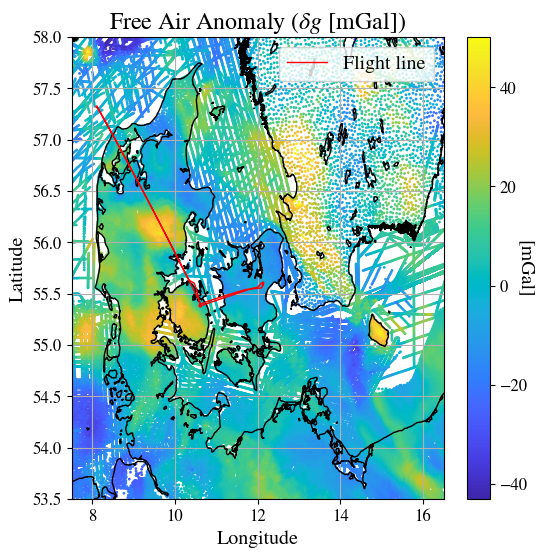

In [9]:
import parula
N = 6
fig = plt.figure(figsize = (N, N))
plt.scatter(freeAir.lon, freeAir.lat, 1, freeAir.FA, cmap=parula.parula_map, zorder = 0)
plt.plot(gnss.lon, gnss.lat, color="red", linewidth=1, zorder = 10, label = "Flight line")
plt.plot(coast.X, coast.Y, color="black", linewidth=1, zorder=5)
cbar = plt.colorbar()
cbar.set_label("[mGal]", rotation=270)
plt.legend(loc = "upper right")
plt.ylim(53.5, 58)
plt.xlim(7.5, 16.5)
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title(r"Free Air Anomaly ($\delta g$ [mGal])")
plt.grid()
plt.show()

## Visualize Profile

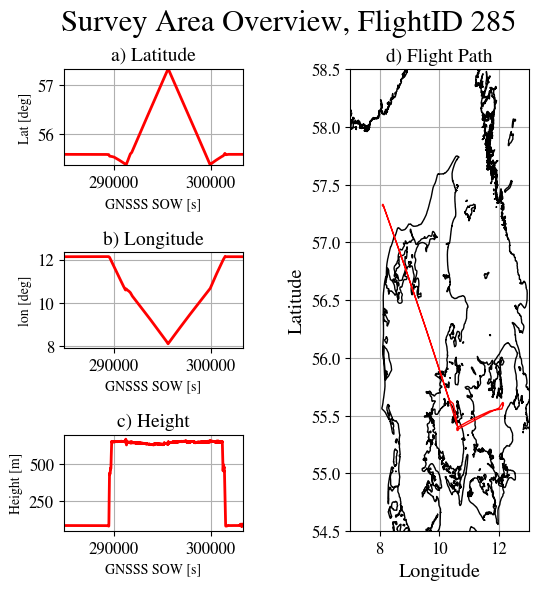

In [82]:
N = 6
import matplotlib.gridspec as gridspec

fig = plt.figure(figsize=(N, N))
fig.suptitle("Survey Area Overview, FlightID 285", fontsize= 22)

# create a grid with 3 rows and 2 columns
gs = gridspec.GridSpec(3, 2, figure=fig)

# add the first three subplots
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[1, 0])
ax3 = fig.add_subplot(gs[2, 0])

# add the fourth subplot
ax4 = fig.add_subplot(gs[0:, 1])

#fig = plt.figure(figsize=figsize)
ax4.plot(coast.X, coast.Y, color="black", linewidth=1)
ax4.plot(gnss.lon, gnss.lat, color="red", linewidth=1)
ax4.grid()
ax4.set_xlabel('Longitude')
ax4.set_ylabel('Latitude')
ax4.set_title(r'Coastline')
ax4.set_xlim(7, 13);
ax4.set_ylim(54.5, 58.5);
ax4.set_title("d) Flight Path", fontsize=14)


ax1.plot(gnss.time, gnss.lat, color="red", linewidth=2)
ax1.grid()
ax1.set_xlabel('GNSSS SOW [s]', fontsize=10)
ax1.set_ylabel('Lat [deg]', fontsize=10)
ax1.set_xlim(gnss.time.values[0], gnss.time.values[-1]);
ax1.set_title("a) Latitude", fontsize=14)
ax1.autoscale(tight=True)

ax2.plot(gnss.time, gnss.lon, color="red", linewidth=2)
ax2.grid()
ax2.set_xlabel('GNSSS SOW [s]', fontsize=10)
ax2.set_ylabel('lon [deg]', fontsize=10)
ax2.set_xlim(gnss.time.values[0], gnss.time.values[-1]);
ax2.set_title("b) Longitude", fontsize=14)

ax3.plot(gnss.time, gnss.h, color="red", linewidth=2)
ax3.grid()
ax3.set_xlabel('GNSSS SOW [s]', fontsize=10)
ax3.set_ylabel('Height [m]', fontsize=10)
ax3.set_xlim(gnss.time.values[0], gnss.time.values[-1]);
ax3.set_title("c) Height", fontsize=14)

plt.subplots_adjust(left=None, bottom=None, right=None, top=0.88, wspace=0.6, hspace=0.9)

#plt.tight_layout()
plt.show()

##  Derive Accelerations from GNSS

In [11]:
def low_pass_filter(data, band_limit, sampling_rate):
    cutoff_index = int(band_limit * data.size / sampling_rate)
    F = np.fft.fft(data)
    F[cutoff_index + 1 : -cutoff_index] = 0
    return np.fft.ifft(F).real

from scipy.signal import butter, lfilter

def butter_bandpass(lowcut, highcut, fs, order=5):
    return butter(order, [lowcut, highcut], fs=fs, btype='band')

def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y


In [12]:
filter_size = 300*2
imu_mov_mean = ds.movmean(imu.bacc3.values, filter_size)
imu_mov_mean_time = ds.movmean(imu.time.values, filter_size)


In [13]:
imu_but_low = ds.but2_v2(imu_mov_mean, 3, ftc, 1/300)
imu_but = ds.but2_v2(imu.bacc3.values, 3, 150, 1/300)


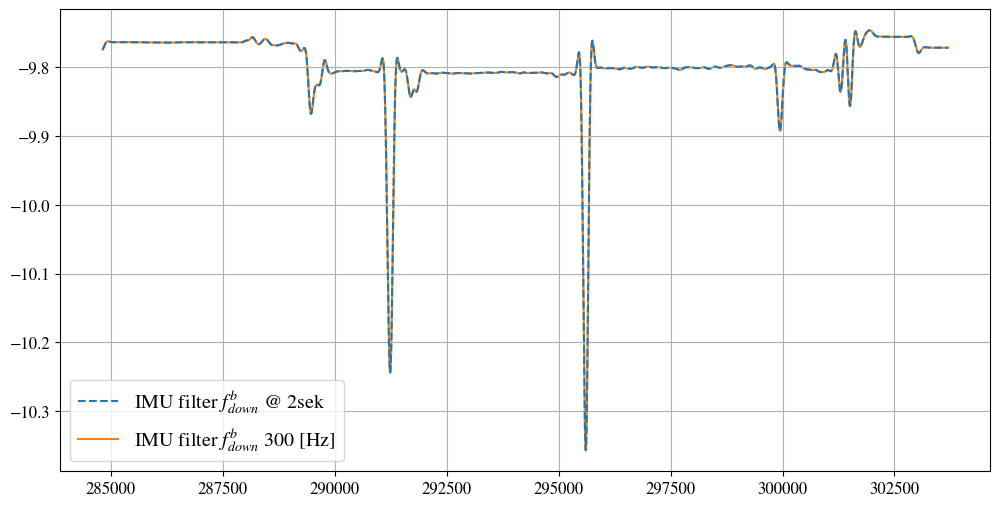

In [14]:


# y = butter_bandpass_filter(imu.bacc3.values, 1/(300*120),1/(300),1/300) + np.mean(imu.bacc3.values)
fig = plt.figure(figsize=(N*2, N))

plt.plot(imu.time, imu_but, label=r"IMU filter $f^b_{down}$ @ 2sek", zorder = 10, linestyle="--")
plt.plot(imu.time.values, imu_but, label=r"IMU filter $f^b_{down}$ 300 [Hz]", zorder = 0)
plt.plot()
plt.legend(loc = "lower left")
plt.grid()

plt.show()

In [15]:
# freq = np.fft.rfft(imu_d_lowpass)


In [16]:
# fig = plt.figure(figsize=(N*2, N))
# plt.plot(freq[1:])


In [17]:
# imu_d_lowpass = low_pass_filter(imu.bacc3.values, 1/(300*120), 1/300)



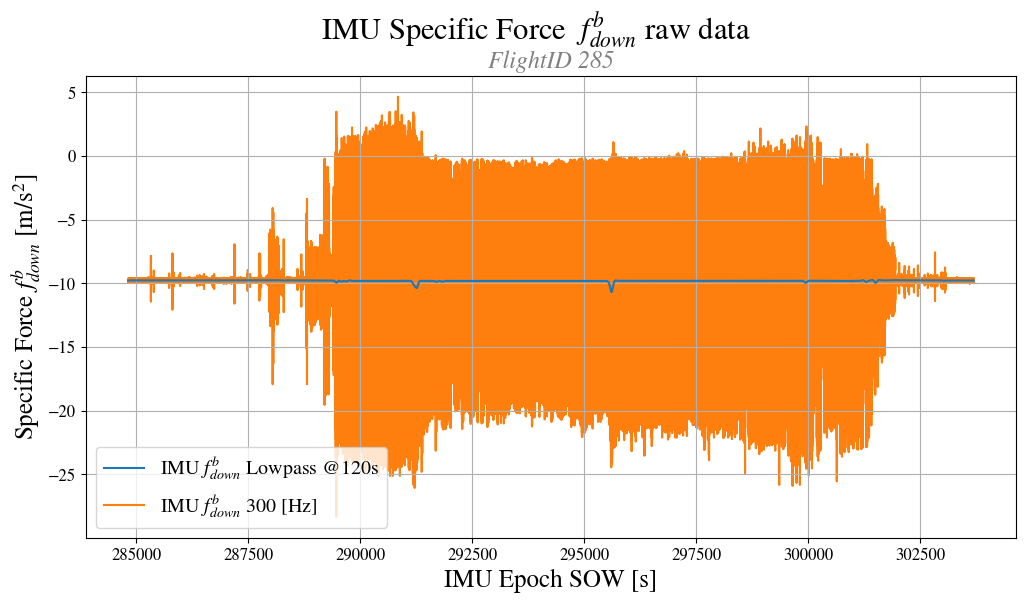

In [79]:
imu_low = ds.but2_v2(imu.bacc3.values, 1, 120, 1/300)
N = 6
fig = plt.figure(figsize=(N*2, N))
# plt.plot(imu.time.values, y, zorder=115)
plt.plot(imu.time.values, imu_low, label=r"IMU $f^b_{down}$ Lowpass @120s", zorder = 10, linewidth = 1.5)
plt.plot(imu.time.values, imu.bacc3.values, label=r"IMU $f^b_{down}$ 300 [Hz]", zorder = 0)
plt.plot()
plt.legend(loc = "lower left")
plt.grid()
plt.xlabel("IMU Epoch SOW [s]", fontsize = 18)
plt.ylabel(r"Specific Force $f_{down}^b$ [m/s$^2$]", fontsize = 18)
# plt.title("IMU Specific Force raw data, DK2022 survey", fontsize = 22, pad=20)
# plt.ylim(-9, -10)
name = Path("Figures", "RAW_IMU.pdf")
plt.suptitle("IMU Specific Force  $f^b_{down}$ raw data \n", fontsize=22, y=.99)
# Add title
plt.title(r"FlightID 285", color="grey", style='italic')
plt.savefig(name)
plt.show()


In [19]:
# imu_GNSS = ds.interpolate_DS(imu.time, imu.bacc3, temp["time"], "linear","extrapolate")
# imu_GNSS_low = ds.but2_v2(imu_GNSS, 1, 120, 1)
# imu_gnss_low_mov = ds.movmean(imu_GNSS_low, 120)
# time_mov = ds.movmean(temp["time"], 120)
# fig = plt.figure(figsize=(N*2, N))
# # plt.plot(imu.time.values, y, zorder=115)
# plt.plot(temp["time"], imu_GNSS_low, label=r"IMU $f^b_{down}$ Lowpass @120s", zorder = 10, linewidth = 1.5)
# plt.plot(temp["time"], imu_GNSS, label=r"IMU $f^b_{down}$ 300 [Hz]", zorder = 0)
# plt.plot(time_mov, imu_gnss_low_mov, label=r"IMU $f^b_{down}$ Lowpass @120s mov", zorder = 15)

In [20]:
import os
ifile = Path("..", "data_DK2022_new", "data", "ROSKILDE16",  "116_air1_ppp_2Hz.txt")
# Extract the input filename and path
input_filename = os.path.basename(ifile)
number = int(input_filename.split('_')[-1][0])

def PPP_freq(ifile): 
    input_filename = os.path.basename(ifile)
    number = int(input_filename.split('_')[-1][0])
    return number

In [21]:
gnss.time.shape
gnss.h.shape

(17997,)

In [22]:
print('Deriving accelerations from GNSS')

temp = {}
# Finite difference 
temp_gps_acc_raw, temp_time = ds.gnss_accelerations_v1(gnss.time.values, gnss.h,"difference")
# temp_gps_acc_raw, temp_time = ds.gnss_accelerations_v1(gnss_time_low, gnss_h_low,"difference")

temp["gps_acc"] = temp_gps_acc_raw
temp["time"]  = temp_time

# Filter signals 
temp_imu_acc = ds.but2_v2(imu.bacc3.values, 3, ftc, 1/300)
# temp_imu_acc = ds.but2_v2(imu_mov_mean, 3, ftc, 1/300)
temp_gps_acc = ds.but2_v2(temp["gps_acc"], 3, ftc, 1)

temp["imu_acc"] = temp_imu_acc
temp["gps_acc"] = temp_gps_acc

# Interpolate 
#temp["imu_acc"] = ds.interpolate_DS(imu.time.values, temp["imu_acc"], temp["time"], "linear","extrapolate")
temp["imu_acc"] = ds.interpolate_DS(imu.time, temp["imu_acc"], temp["time"], "linear","extrapolate")

print("> Done")

Deriving accelerations from GNSS
> Done


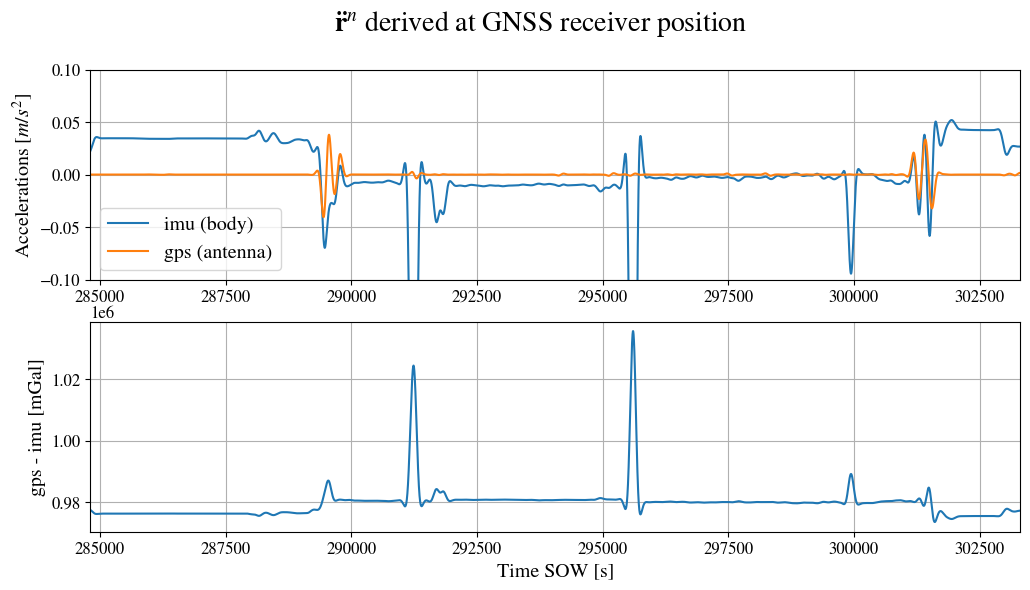

In [23]:
fig, ax = plt.subplots(2,1, figsize = (N*2,N))
ax[0].plot(temp["time"], temp["imu_acc"]-np.mean(temp["imu_acc"]), label="imu (body)")
ax[0].plot(temp["time"], temp["gps_acc"], label="gps (antenna)")
ax[0].set_xlim(temp["time"][0], temp["time"][-1])
ax[0].set_ylim(-0.1, 0.1)
ax[0].set_ylabel(r"Accelerations [$m/s^{2}$]")
# ax[0].set_xlabel('Temp time SOW [s]')
ax[0].grid()
ax[0].legend(loc="lower left")

ax[1].plot(temp["time"], (temp["gps_acc"] - temp["imu_acc"])*10**5)
ax[1].grid()
ax[1].set_xlim(temp["time"][0], temp["time"][-1])
ax[1].set_ylabel("gps - imu [mGal]")
ax[1].set_xlabel('Time SOW [s]')
fig.suptitle(r"$\mathbf{\ddot{r}}^n$ derived at GNSS receiver position", fontsize=20)
plt.show()

In [24]:
# fig = plt.figure(figsize=(N*2, N))
# plt.plot(temp["time"], temp["imu_acc"]-np.mean(temp["imu_acc"]), label="imu (body)")
# plt.plot(temp["time"], temp["gps_acc"], label="gps (antenna)")
# plt.xlim(temp["time"][0], temp["time"][-1])
# plt.ylim(-0.1, 0.1)
# plt.ylabel(r"Accelerations [$m/s^{2}$]")
# plt.xlabel('Temp time SOW [s]')
# plt.grid()
# plt.legend()

# plt.show()

# fig = plt.figure(figsize=(N*2, N))
# plt.plot(temp["time"], (temp["gps_acc"] - temp["imu_acc"])*10**5)
# plt.grid()
# plt.xlim(temp["time"][0], temp["time"][-1])
# plt.ylabel("gps - imu [mGal]")
# plt.xlabel('Temp time SOW [s]')
# plt.show()

## Translate GNSS Position to IMU Location

In [25]:
print("Translate GNSS Position to IMU Location")
nav_key = ["roll", "pitch", "yaw"]
for i in range(0, len(nav_key)): 
    gnss[nav_key[i]] = ds.interpolate_DS(nav.time, nav[nav_key[i]], gnss.time, "linear", "extrapolate")


olat, olon, oh = ds.pos_translate_v1(gnss.lat, gnss.lon, gnss.h, gnss.roll, gnss.pitch, gnss.yaw, lever_arm)
gnss["imu_lat"] = olat
gnss["imu_lon"] = olon
gnss["imu_h"] = oh

print("> Done")

Translate GNSS Position to IMU Location


100%|██████████| 17997/17997 [00:01<00:00, 15567.39it/s]

> Done


## Derive Accelerations from GNSS

In [26]:
print("Deriving accelerations from IMU Location")

# Finite difference
temp_gps_acc2, _= ds.gnss_accelerations_v1(gnss.time.values,gnss.imu_h, "difference")
temp["gps_acc2"], index = ds.cutoff_bound(temp_gps_acc2)
temp["time_cut"] = temp["time"][:index]
temp["imu_acc_cut"] = temp["imu_acc"][:index]

# temp["gps_acc2"] = temp_gps_acc2
# Filter signals  
temp_gps_acc2 = ds.but2_v2(temp["gps_acc2"], 3, ftc, 1)
temp["gps_acc2"] = temp_gps_acc2

print("> Done")

Deriving accelerations from IMU Location
The threshold value 0.001 was found at index 18233.
> Done


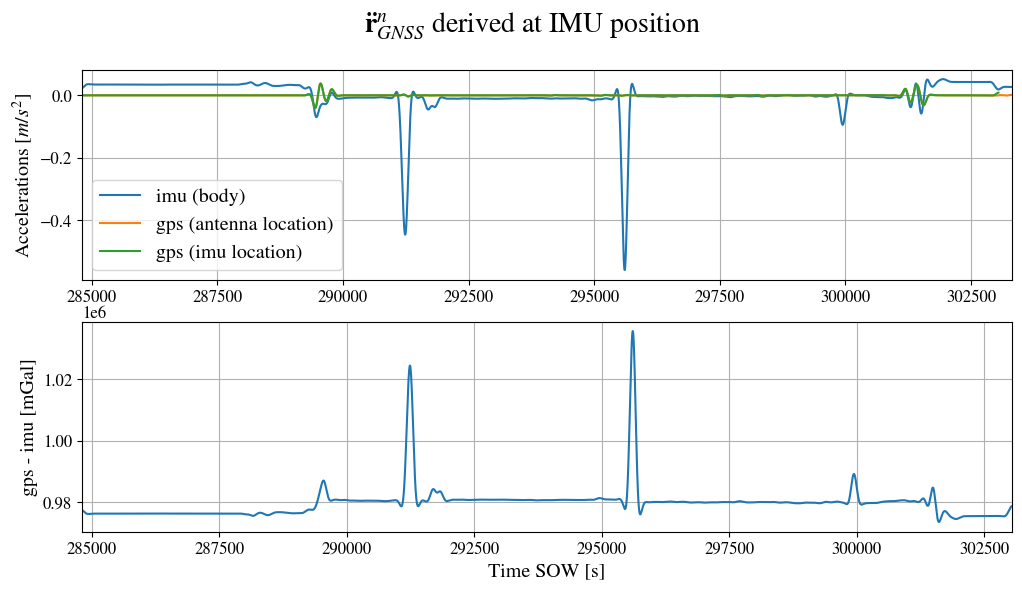

In [27]:
# Plot Results 
# fig = plt.figure(figsize=(N*2, N))
# plt.plot(temp["time"], temp["imu_acc"]-np.mean(temp["imu_acc"]), label="imu (body)")
# plt.plot(temp["time"], temp["gps_acc"], label="gps (antenna location)")
# plt.plot(temp["time_cut"], temp["gps_acc2"], label="gps (imu location)")
# plt.xlim(temp["time"][0], temp["time"][-1])
# plt.ylim(-0.1, 0.1)
# plt.ylabel(r"Accelerations [$m/s^{2}$]")
# plt.grid()
# plt.legend()

# plt.show()

# fig = plt.figure(figsize=(N*2, N))
# plt.plot(temp["time_cut"], (temp["gps_acc2"] - temp["imu_acc_cut"])*10**5)
# plt.grid()
# plt.xlim(temp["time_cut"][0], temp["time_cut"][-1])
# plt.ylabel("gps - imu [mGal]")
# plt.show()


fig, ax = plt.subplots(2,1, figsize = (N*2,N))
ax[0].plot(temp["time"], temp["imu_acc"]-np.mean(temp["imu_acc"]), label="imu (body)")
ax[0].plot(temp["time"], temp["gps_acc"], label="gps (antenna location)")
ax[0].plot(temp["time_cut"], temp["gps_acc2"], label="gps (imu location)")
ax[0].set_xlim(temp["time"][0], temp["time"][-1])
# ax[0].set_ylim(-0.1, 0.1)
ax[0].set_ylabel(r"Accelerations [$m/s^{2}$]")
ax[0].grid()
ax[0].legend(loc = "lower left")

ax[1].plot(temp["time_cut"], (temp["gps_acc2"] - temp["imu_acc_cut"])*10**5)
ax[1].grid()
ax[1].set_xlim(temp["time_cut"][0], temp["time_cut"][-1])
ax[1].set_ylabel("gps - imu [mGal]")
ax[1].set_xlabel("Time SOW [s]")
fig.suptitle(r"$\mathbf{\ddot{r}}^n_{GNSS}$ derived at IMU position", fontsize=20)
plt.show()


## Transform IMU Accelerations into North-East-Down-Frame


In [28]:

print("Interpolating IMU Accelerations")
for key, value in nav.items(): 
    imu[key] = ds.interpolate_DS(nav.time, value, 
                                 imu.time, "linear", False, "extrapolate")
print("> Done")

Interpolating IMU Accelerations
> Done


In [29]:
print("Rotating IMU Accelerations")
imu_bacc = np.vstack([imu.bacc1.values, imu.bacc2.values, imu.bacc3.values]).T
imu_att = np.vstack([imu.roll.values, imu.pitch.values, imu.yaw.values]).T

# Transform Accelerations 
imu_nacc = ds.b2n_v1(imu.time, imu_bacc, imu_att)
temp["nacc"] = imu_nacc.T  # Using temp["nacc"] instead of imu.nacc as the pd datafram of imu can not take the [N x 3]

# Filter signal 
temp["imu_acc2"] = ds.but2_v2(temp["nacc"][:,2], 3, ftc, 1/300)

# Interpolate 
temp["imu_acc2"] = ds.interpolate_DS(imu.time, temp["imu_acc2"], temp["time"], "linear", False, "extrapolate")
temp["imu_acc2"] = temp["imu_acc2"][:index]
print("> Done")

Rotating IMU Accelerations
> Done


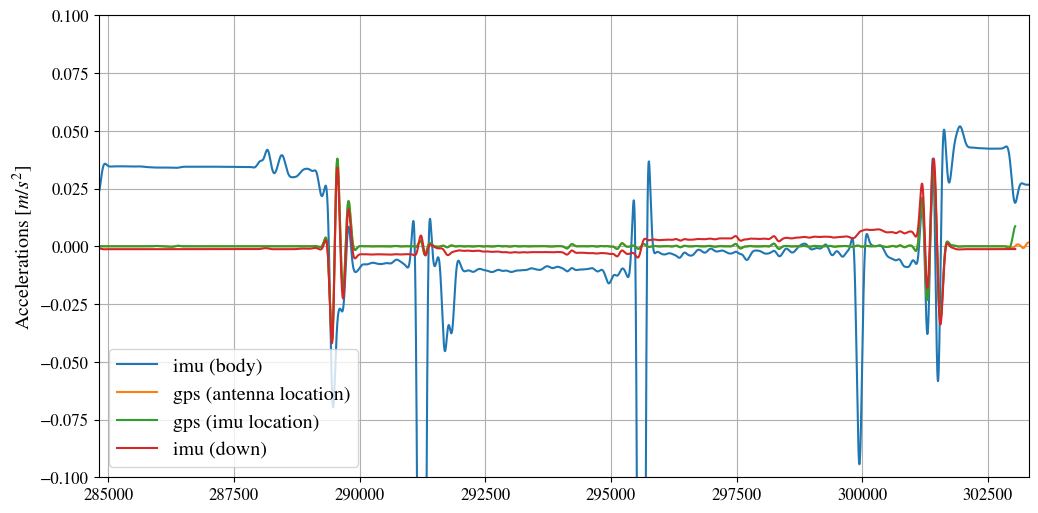

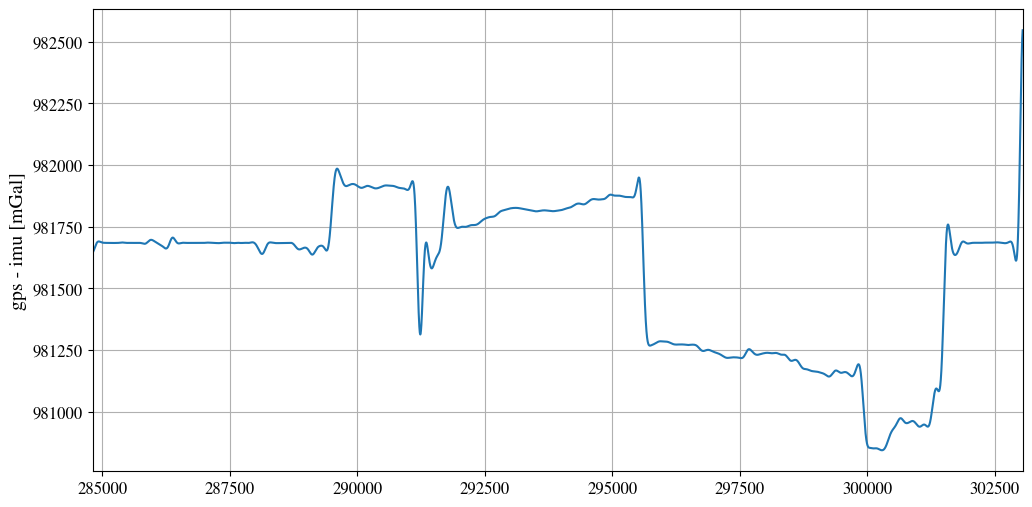

In [30]:
# Plot results 
fig = plt.figure(figsize=(N*2, N))
plt.plot(temp["time"], temp["imu_acc"]-np.mean(temp["imu_acc"]), label="imu (body)")
plt.plot(temp["time"], temp["gps_acc"], label="gps (antenna location)")
plt.plot(temp["time_cut"], temp["gps_acc2"], label="gps (imu location)")
plt.plot(temp["time_cut"], temp["imu_acc2"]-np.mean(temp["imu_acc2"]), label="imu (down)")
plt.xlim(temp["time"][0], temp["time"][-1])
plt.ylabel(r"Accelerations [$m/s^{2}$]")
plt.grid()
plt.legend(loc="lower left")
plt.ylim(-0.1, 0.1)
plt.show()

fig = plt.figure(figsize=(N*2, N))
plt.plot(temp["time_cut"], (temp["gps_acc2"] - temp["imu_acc2"])*10**5)
plt.grid()
plt.xlim(temp["time_cut"][0], temp["time_cut"][-1])
plt.ylabel("gps - imu [mGal]")
plt.show()

## Compute Transport Rate 

In [31]:
print("Computing Transport-Rate (Eotvos and Coriolis) Effect")

vel = np.vstack([imu.vn.values, imu.ve.values, imu.vd.values]).T
pos = np.vstack([imu.lat.values, imu.lon.values, imu.h.values]).T

# Compute Transport Rate 
imu_tacc = ds.transport_rate_v2(imu.time, vel, pos)
temp["imu_tacc"] = imu_tacc

# Filter signal 
temp_trans = ds.but2_v2(temp["imu_tacc"][:,2], 3, ftc, 1/300)
temp["trans"] = temp_trans

# Interpolate 
temp["trans"] = ds.interpolate_DS(imu.time, temp["trans"], 
                               temp["time"], "linear", False, "extrapolate")
temp["trans"] = temp["trans"][:index]
# Correct for transport rate 
temp["imu_acc3"] = temp["imu_acc2"] - temp["trans"]

print("> Done")

Computing Transport-Rate (Eotvos and Coriolis) Effect
> Done


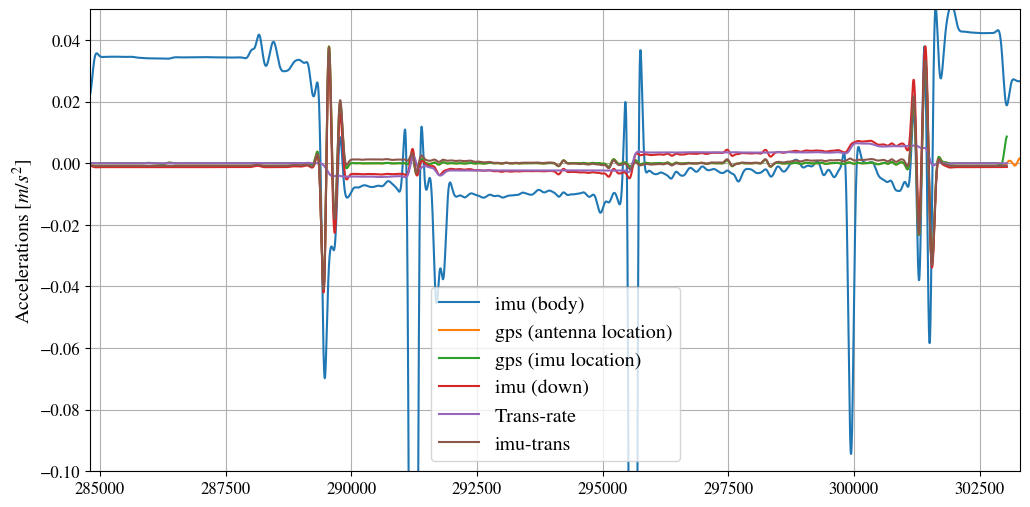

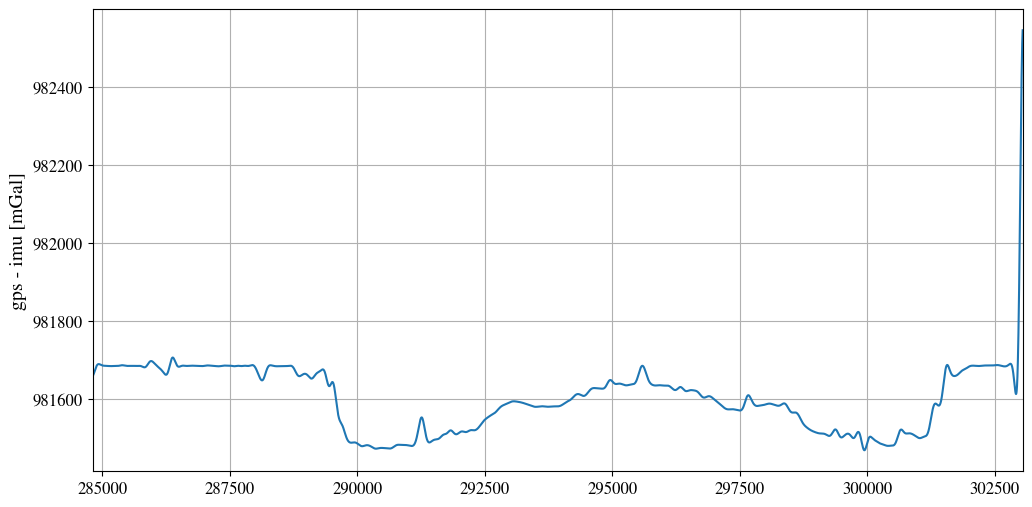

In [32]:
# Plot Results 
fig = plt.figure(figsize=(N*2, N))
plt.plot(temp["time"], temp["imu_acc"]-np.mean(temp["imu_acc"]), label="imu (body)")
plt.plot(temp["time"], temp["gps_acc"], label="gps (antenna location)")
plt.plot(temp["time_cut"], temp["gps_acc2"], label="gps (imu location)")
plt.plot(temp["time_cut"], temp["imu_acc2"]-np.mean(temp["imu_acc2"]), label="imu (down)")
plt.plot(temp["time_cut"], temp["trans"], label="Trans-rate")
plt.plot(temp["time_cut"], temp["imu_acc3"]-np.mean(temp["imu_acc3"]), label="imu-trans")
plt.xlim(temp["time"][0], temp["time"][-1])
plt.ylabel(r"Accelerations [$m/s^{2}$]")
plt.grid()
plt.ylim(-0.1, 0.05)
plt.legend()

plt.show()

fig = plt.figure(figsize=(N*2, N))
plt.plot(temp["time_cut"], (temp["gps_acc2"] - temp["imu_acc3"])*10**5)
plt.grid()
plt.xlim(temp["time_cut"][0], temp["time_cut"][-1])
plt.ylabel("gps - imu [mGal]")
plt.show()

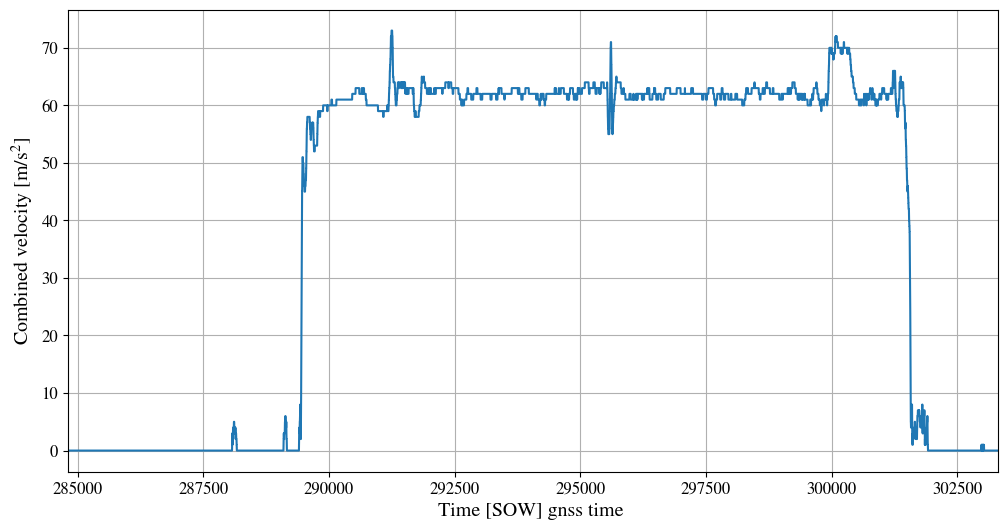

In [33]:
vel_dic = {}
vn_gnss = ds.interpolate_DS(nav.time, nav.vn, temp["time"], "linear", "extrapolate")
nav_key = ["vn", "ve", "vd"]
for i in range(0, len(nav_key)): 
    vel_dic[nav_key[i]] = ds.interpolate_DS(nav.time, nav[nav_key[i]], temp["time"],
                                             "linear", "extrapolate")

vel_scalar = np.round(np.sqrt(vel_dic["vn"]**2 + vel_dic["ve"]**2 + vel_dic["vd"]**2))

plt.show()
fig = plt.figure(figsize=(N*2, N))
plt.plot(temp["time"], vel_scalar)
plt.grid()
plt.xlim(temp["time"][0], temp["time"][-1])
plt.ylabel(r"Combined velocity [m/s$^2$]")
plt.xlabel("Time [SOW] gnss time ")
plt.show()


## Derive Gravity 

In [34]:
print("Deriving Gravity Acceleration")
@dataclass
class solution: 
    time: np.ndarray
    lat: np.ndarray
    lon: np.ndarray
    h: np.ndarray
    imu_acc: np.ndarray
    gps_acc: np.ndarray 
    gamma: np.ndarray

nav_key2 = ["lat", "lon", "h"]
for i in range(0, len(nav_key)): 
    temp[nav_key2[i]] = ds.interpolate_DS(nav.time, nav[nav_key2[i]], 
                                          temp["time"], "linear", "extrapolate")


solution = solution(temp["time_cut"],temp["lat"][:index],temp["lon"][:index],temp["h"][:index],
                    temp["imu_acc3"],temp["gps_acc2"], [])

gamma, _, _ = ds.normal_gravity_precise_v1(solution.lat.reshape(-1,1),solution.lon.reshape(-1,1),solution.h.reshape(-1,1), 3)
#gamma, _, _ = normal_gravity_precise_v1(solution.lat.reshape(-1,1),solution.lon.reshape(-1,1),solution.h.reshape(-1,1), 3)

solution.gamma = gamma.down

# Derive Gravity 
solution.g = solution.gps_acc - solution.imu_acc
solution.dg = (solution.g.reshape(-1,1) - solution.gamma)*10**5

print("> Done")

Deriving Gravity Acceleration
> Done


In [35]:
solution.dg.reshape(1,-1).shape

(1, 18233)

In [36]:
solution.dg, index = ds.cutoff_bound(solution.dg.reshape(1,-1))
solution.time = solution.time[:index]
solution.dg = solution.dg.reshape(-1,1)[:index]
solution.dg.shape

The threshold value 0.001 was found at index 17554.


(17554, 1)

In [37]:
dg_corr = ds.bias_drift_corr(solution.dg, solution.time, vel_scalar[:index])
#time_ref, dg_ref, idx = bias_drift_corr(solution.dg, solution.time, vel_scalar[:index])

In [38]:
# fig, ax1 = plt.subplots(figsize=(N*2, N))
# ax1.plot(time_ref, dg_ref, '.-', label="Reference time cutoff", color="red")
# ax1.plot(solution.time, solution.dg, label="Full time series")
# ax1.grid()
# ax1.set_xlabel("Time, [SOW]")
# ax1.set_ylabel("Gravity Disturbance [mGal]")
# ax2 = ax1.twinx()
# ax2.plot(temp["time"][:index], vel_scalar[:index], label="Velocity", color="green")
# ax2.set_ylabel(r"Scalar velocity [m/s$^2$]")
# lines, labels = ax1.get_legend_handles_labels()
# lines2, labels2 = ax2.get_legend_handles_labels()
# ax2.legend(lines + lines2, labels + labels2, loc='upper left')



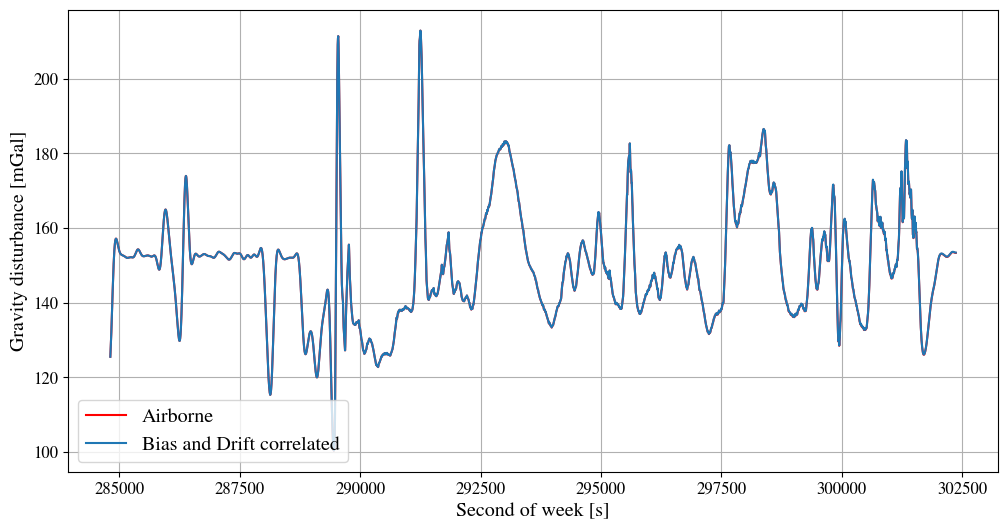

In [39]:
# Plot results...

fig = plt.figure(figsize=(N*2, N))

#plt.plot(egm08.time, egm08.dg, label="EGM08")
plt.plot(solution.time, solution.dg, label="Airborne", color="red")
plt.plot(solution.time, dg_corr, label="Bias and Drift correlated")
# plt.plot(gnss.time, gnss.freeAir_flight, label="Free Air Reference")
# plt.xlim(temp["time"][0], temp["time"][-1])
#plt.ylim(100, np.max(dg_corr))
plt.ylabel(r"Gravity disturbance [mGal]")
plt.xlabel("Second of week [s]")
plt.grid()
plt.legend(loc="lower left")
# plt.xlim(285000, 302500)

plt.show()

In [40]:
# import pandas as pd
# file6 = Path("..", "data_DK2022_new", "data", "results", "DK22_inat_285.txt")
# result = pd.read_csv(file6.as_posix(), skiprows=1, delim_whitespace=True, header=None, names=["FlightID", "Lat", "Lon", "h", "Bank", "Elevation", "Heading", "g", "dg", "GPS_Time", "DOY", "Lineno"])
# result

In [41]:
def echo(): 
    return print(".")
echo()

.


In [42]:
import pyproj
from pyproj import Transformer
survey = {}
survey["time"] = solution.time
survey["dg"] = solution.dg

pipeline = "+ellps=GRS80 +proj=pipeline +step +proj=utm +zone=32"
transform_object = Transformer.from_pipeline(pipeline)
geodetic_corr = [temp["lon"], temp["lat"], temp["h"]]
UTM_corr = transform_object.transform(*geodetic_corr)

fwd = np.zeros((len(np.arange(7050,10700)),2))
#bwd = np.zeros((len(np.arange(10900,14550)),2))
fwd[:,0] = UTM_corr[0][7050:10700]; fwd[:,1] = UTM_corr[1][7050:10700]
#bwd[:,0] = UTM_corr[0][10900:14550]; bwd[:,1] = UTM_corr[1][10900:14550]
survey["fwd"] = fwd
survey["UTM"] = UTM_corr   #[Easting Northing, h]
survey["idx_orig"] = np.arange(0,len(UTM_corr[0]))
survey["fwd_idx"] = np.arange(7051, 10701)
# N = 6"
# fig = plt.figure(figsize=(N*2, N))
# plt.plot(UTM_corr[0], UTM_corr[1], label="test flight")
# #plt.plot(UTM_corr[0][7050:10700], UTM_corr[1][7050:10700])
# #plt.plot(UTM_corr[0][10900:14550], UTM_corr[1][10900:14550], color="red")
# plt.ylabel("utm_y")
# plt.xlabel("utm_x")
# plt.grid()
# plt.legend()

# plt.show()

# fig = plt.figure(figsize=(N*2, N))
# plt.plot(temp["time"], UTM_corr[1], label="test flight")
# plt.ylabel("utm_x")
# plt.xlabel("time")
# plt.grid()
# plt.legend()

# plt.show()


3 values closest to 0.0:
Value: 0.8441426541498913, Index: 100
Value: 3.3751553730066917, Index: 99
Value: 4.69064379401695, Index: 197


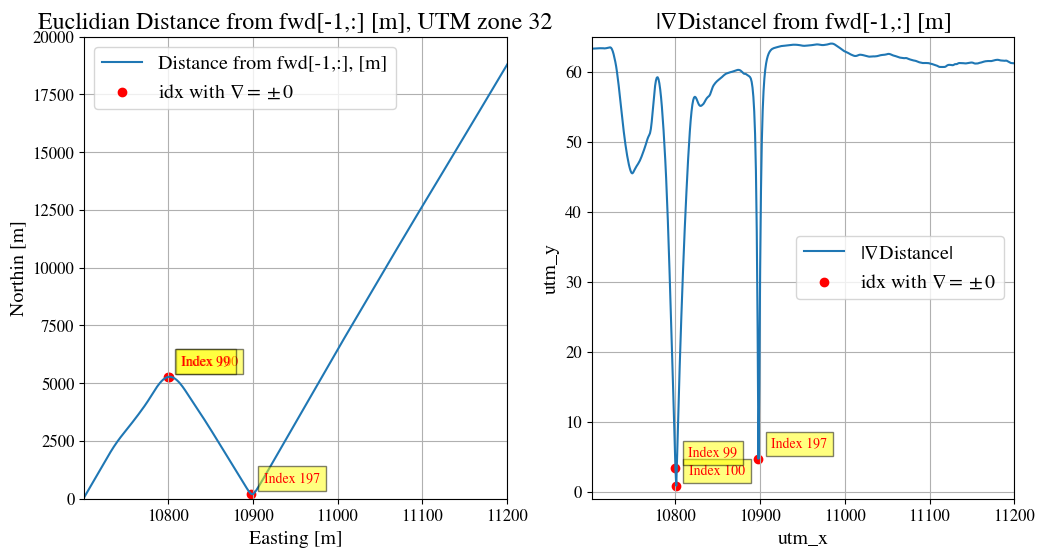

In [43]:
def find_nearest(array, k):
    idx = array.argsort()[:k]
    
    print(f"{k} values closest to 0.0:")
    for i in idx:
        print(f"Value: {array[i]}, Index: {i}")
    return idx


dist = np.sqrt((survey["fwd"][-1,0] - survey["UTM"][0][10700:-1])**2 
               + (survey["fwd"][-1,1] - survey["UTM"][1][10700:-1])**2)
survey["dist"] = dist 
min_dist = min(dist)  # SKal slettes?? 
#idx = np.where(dist == min_dist)
#print(idx) #not clear, as the closest point is the next [1HZ] measurement... 

diff_dist = np.gradient(survey["dist"][1:np.abs(10700-11201)])
survey["diff_dist"] = diff_dist
idx = find_nearest(np.abs(survey["diff_dist"]), 3)
labels = ["Index 100", "Index 99", "Index 197"]

# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(N*2, N))

# Plot on the first subplot
ax1.plot(np.arange(10701, len(survey["UTM"][0])), survey["dist"], label="Distance from fwd[-1,:], [m]")
ax1.scatter(10701+idx, np.abs(survey["dist"][idx]), color="red", label=r"idx with $\nabla =\pm 0$")
ax1.set_title("Euclidian Distance from fwd[-1,:] [m], UTM zone 32")
ax1.set_xlabel("Easting [m]")
ax1.set_ylabel("Northin [m]")
ax1.set_xlim(10701, 11200)
ax1.set_ylim(0, 20000)
ax1.grid()
ax1.legend()
for i in range(len(idx)):
    ax1.text(x=10701+idx[i]+15,y=np.abs(survey["dist"][idx[i]])+500,s=labels[i], 
    fontdict=dict(color="red",size=10),
    bbox=dict(facecolor="yellow",alpha=0.5))

# Plot on the second subplot
ax2.plot(np.arange(10701, 10701+len(survey["diff_dist"])), np.abs(survey["diff_dist"]), label=r"$|\nabla$Distance|")
ax2.scatter(10701+idx, np.abs(survey["diff_dist"][idx]), color="red", label=r"idx with $\nabla =\pm 0$")
ax2.set_title(r"$|\nabla$Distance| from fwd[-1,:] [m]")
ax2.set_xlabel("utm_x")
ax2.set_ylabel("utm_y")
ax2.set_xlim(10701, 11200)
ax2.set_ylim(-1, max(survey["diff_dist"])+1)
ax2.grid()
ax2.legend(loc='center right')
for i in range(len(idx)):
    ax2.text(x=10701+idx[i]+15,y=np.abs(survey["diff_dist"][idx[i]])+1.6,s=labels[i], 
    fontdict=dict(color="red",size=10),
    bbox=dict(facecolor="yellow",alpha=0.5))
# Show the plot
plt.show()


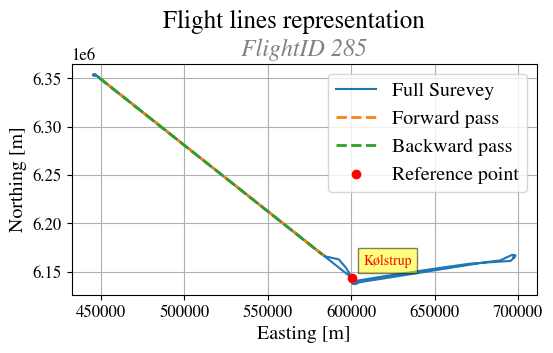

In [44]:
# So we work from index 197, as this is the closest starting point for the bwd when compared to the chosen fwd endpoint. 
idx = 197 # Determined through distance from fwd[-1,:]
bwd = np.zeros(fwd.shape)
bwd[:,0] = survey["UTM"][0][(10700+idx):(10700+idx+len(survey["fwd"][:,0]))] 
bwd[:,1] = survey["UTM"][1][(10700+idx):(10700+idx+len(survey["fwd"][:,0]))]
survey["bwd"] = bwd
survey["bwd_idx"] = np.arange(10700+idx, 10700+idx+len(fwd[:,0]+1))

# Distance from Odense - Linear system to create line... 
# 
length_of_line_fwd = np.sqrt((survey["fwd"][-1,0] - survey["fwd"][0,0])**2 
                             + (survey["fwd"][-1,1] - survey["fwd"][-1,-1] )**2)
freq_fwd = length_of_line_fwd/len(survey["fwd"][:,0])
length_of_line_bwd = np.sqrt((survey["bwd"][-1,0] - survey["bwd"][0,0])**2 
                             + (survey["bwd"][-1,1] - survey["bwd"][-1,-1] )**2)
freq_bwd = length_of_line_bwd/len(survey["bwd"][:,0])

avg_freq = (freq_fwd + freq_bwd)/2  #Frequency of measurements [#measurements/m]
# 55.427809, 10.584149, Coordinates for Kølstrup Forsamlingshus - on line with the flightlines. 
# h = 0m - This is a rough estimation, height above geoid btv... setting geoid to sealevel. 
fors = [10.584149, 55.427809, 0]
UTM_fors = transform_object.transform(*fors)
survey["utm_ref"] = UTM_fors    # Reference point in UTM32 



fig = plt.figure(figsize=(N, N/2))
plt.plot(survey["UTM"][0], survey["UTM"][1], label="Full Surevey")
plt.plot(survey["fwd"][:,0], survey["fwd"][:,1], label = "Forward pass", linestyle="--", linewidth=2)
plt.plot(survey["bwd"][:,0], survey["bwd"][:,1], label = "Backward pass", linestyle="--", linewidth=2)
plt.scatter(survey["utm_ref"][0], survey["utm_ref"][1], color="red", zorder=10, label = "Reference point")
plt.ylabel("Northing [m]")
plt.xlabel("Easting [m]")
plt.grid()
plt.legend()
plt.text(x=survey["utm_ref"][0]+7000,y=survey["utm_ref"][1]+14000,s=r"Kølstrup", 
    fontdict=dict(color="red",size=10),
    bbox=dict(facecolor="yellow",alpha=0.5))
plt.suptitle("Flight lines representation \n", fontsize=18, y=1.06)
plt.title(r"FlightID 285", color="grey", style='italic')
name = Path("Figures", "Flight_lines_285.pdf")
plt.savefig(name)
plt.show()


In [45]:
gnss.keys()

Index(['lat', 'lon', 'h', 'time', 'freeAir_flight', 'roll', 'pitch', 'yaw',
       'imu_lat', 'imu_lon', 'imu_h'],
      dtype='object')

In [46]:
nav.keys()

Index(['lat', 'lon', 'h', 'vn', 've', 'vd', 'roll', 'pitch', 'yaw', 'time'], dtype='object')

Minimum and Maximum distance on fwd pass: 28739.709081677258m,
 Maximum: 256129.39367111248m
Minimum and Maximum distance on bwd pass: 29895.64523810463m,
 Maximum: 256205.5882716447m


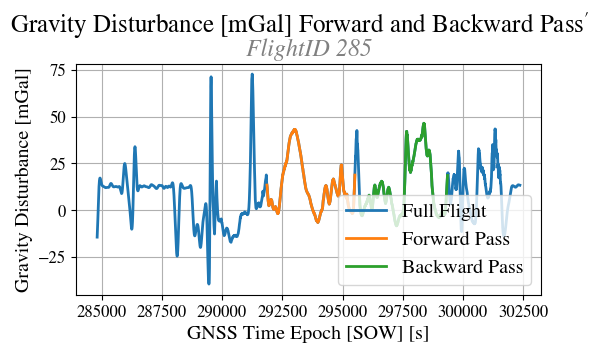

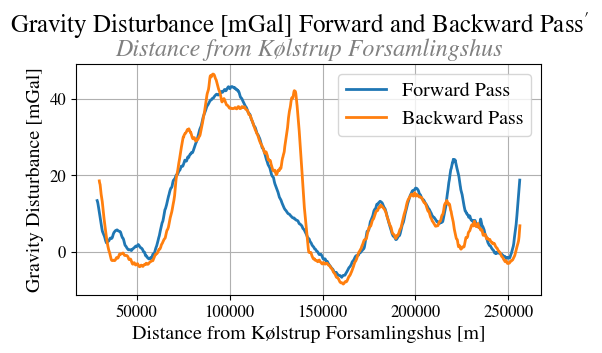

In [47]:
# LS solution for the line extension through to Kølstrup, to determine best reference point

# d = np.vstack([fwd[:,1], bwd[:,1]]).reshape(-1,1)
# t = np.vstack([fwd[:,0], bwd[:,0]]).reshape(-1,1)
# G = np.hstack([np.ones(len(d)).reshape(-1,1), t])
# m =  np.linalg.lstsq(G, d, rcond=None)[0]

# Der skal lige overvejes om dette giver mening, => Hvor meget mere præcis validering kommer der ud af det? 
#print(survey.keys())

## Calculate distance from reference point (fwd and bwd)
dist_fwd = np.sqrt((survey["fwd"][:,0] - survey["utm_ref"][0])**2 
                   + (survey["fwd"][:,1] - survey["utm_ref"][1])**2)
survey["dist_fwd"] = dist_fwd
dist_bwd = np.sqrt((survey["bwd"][:,0] - survey["utm_ref"][0])**2 + (survey["bwd"][:,1] - survey["utm_ref"][1])**2)
survey["dist_bwd"] = dist_bwd

print(f"Minimum and Maximum distance on fwd pass: {min(dist_fwd)}m,\n Maximum: {max(dist_fwd)}m")
print(f"Minimum and Maximum distance on bwd pass: {min(dist_bwd)}m,\n Maximum: {max(dist_bwd)}m")



corr = np.corrcoef(survey["dg"][survey["fwd_idx"]].reshape(-1,), np.flip(survey["dg"][survey["bwd_idx"]]).reshape(-1,))


fig = plt.figure(figsize=(N, N/2))
plt.plot(survey["time"], survey["dg"]-140, label="Full Flight",linewidth=2)
plt.plot(survey["time"][survey["fwd_idx"]], survey["dg"][survey["fwd_idx"]]-140, label="Forward Pass", linewidth=2)
plt.plot(survey["time"][survey["bwd_idx"]], survey["dg"][survey["bwd_idx"]]-140, label="Backward Pass", linewidth=2)
plt.ylabel("Gravity Disturbance [mGal]")
plt.xlabel("GNSS Time Epoch [SOW] [s]")
# plt.xlim(survey["time"][survey["fwd_idx"][0]]-1000, survey["time"][survey["bwd_idx"][-1]]+1000)
#plt.ylim(120, 240)
plt.grid()
plt.legend(loc="lower right")
# plt.title("Gravity Disturbance [mGal] Forward and Backward lines")
plt.suptitle("Gravity Disturbance [mGal] Forward and Backward Pass$\'$ \n", fontsize=18, y=1.06)
plt.title(r"FlightID 285", color="grey", style='italic')
# name = Path("Figures", "dg_285_fwd_bwd.png")
# plt.savefig(name)
plt.show()


fig = plt.figure(figsize=(N,N/2))
plt.plot(survey["dist_fwd"].reshape(-1,1), survey["dg"][survey["fwd_idx"]]-140, label="Forward Pass", linewidth=2)
plt.plot(survey["dist_bwd"].reshape(-1,1), survey["dg"][survey["bwd_idx"]]-140, label="Backward Pass", linewidth=2)
plt.ylabel("Gravity Disturbance [mGal]")
plt.xlabel(r"Distance from Kølstrup Forsamlingshus [m]")
plt.grid()
plt.legend(loc="upper right")
plt.suptitle("Gravity Disturbance [mGal] Forward and Backward Pass$\'$ \n", fontsize=18, y=1.06)
# Add title
plt.title(r"Distance from Kølstrup Forsamlingshus", color="grey", style='italic')
# plt.text(x=20000,y=131,s="Corr(fwd, bwd) = 0.88", 
#     fontdict=dict(color="red",size=10),
#     bbox=dict(facecolor="yellow",alpha=0.5))
# name=Path("Figures", "dg_285_comp_lines.png")
# plt.savefig(name)
plt.show()

In [48]:
bwd_add_fwdPOS = ds.interpolate_DS(survey["dist_bwd"], 
                                   survey["dg"][survey["bwd_idx"]].reshape(-1)-140, 
                                   survey["dist_fwd"], 
                                   "linear", "extrapolate")

diff = survey["dg"][survey["fwd_idx"]].reshape(-1)-140 - bwd_add_fwdPOS
print(ds.RMS(diff))


7.1191585459604525


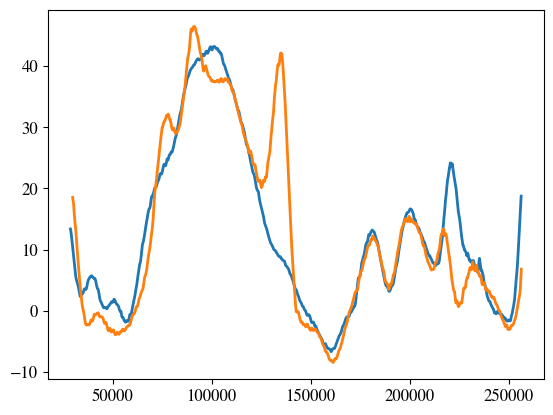

In [49]:

plt.plot(survey["dist_fwd"].reshape(-1,1), survey["dg"][survey["fwd_idx"]]-140, label="Forward Pass", linewidth=2)
plt.plot(survey["dist_bwd"].reshape(-1,1), survey["dg"][survey["bwd_idx"]]-140, label="Backward Pass", linewidth=2)


In [50]:
# idx = np.hstack([survey["fwd_idx"], survey["bwd_idx"]])
# fig = plt.figure(figsize=(N*2, N))
# vn_diff = temp["vn"][survey["fwd_idx"]] - np.flip(temp["vn"][survey["bwd_idx"]])
# plt.plot(survey["dist_fwd"][:-1], np.diff(ve_diff - np.mean(ve_diff)))
# plt.grid()
# plt.show()

In [51]:
survey.keys()

dict_keys(['time', 'dg', 'fwd', 'UTM', 'idx_orig', 'fwd_idx', 'dist', 'diff_dist', 'bwd', 'bwd_idx', 'utm_ref', 'dist_fwd', 'dist_bwd'])

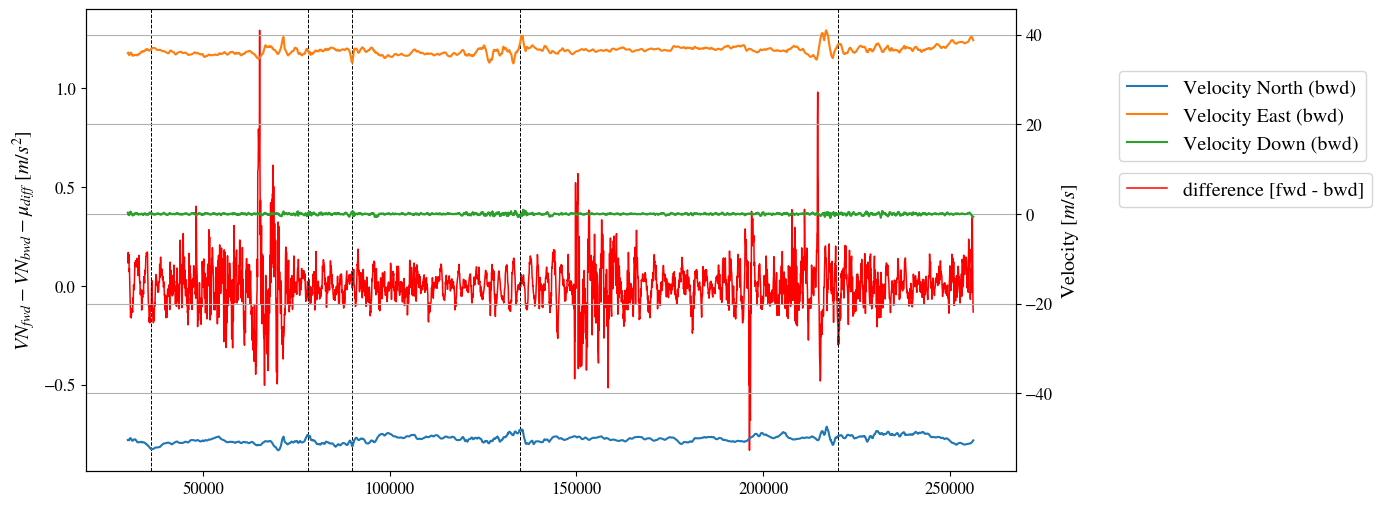

In [52]:
# Interpolate 
temp["vn"] = ds.interpolate_DS(imu.time, imu.vn, 
                                      temp["time"], "linear", False, "extrapolate")
temp["ve"] = ds.interpolate_DS(imu.time, imu.ve, 
                                      temp["time"], "linear", False, "extrapolate")
temp["vd"] = ds.interpolate_DS(imu.time, imu.vd, 
                                      temp["time"], "linear", False, "extrapolate")

idx = np.hstack([survey["fwd_idx"], survey["bwd_idx"]])
vn_diff = temp["vn"][survey["fwd_idx"]] - np.flip(temp["vn"][survey["bwd_idx"]])
ve_diff = temp["ve"][survey["fwd_idx"]] - np.flip(temp["ve"][survey["bwd_idx"]])
vd_diff = temp["vd"][survey["fwd_idx"]] - np.flip(temp["vd"][survey["bwd_idx"]])


anomaly_idx = np.array([36000, 78000, 90000, 135000, 220000])

fig, ax = plt.subplots(figsize=(N*2, N))
for i in range(len(anomaly_idx)): 
    ax.axvline(anomaly_idx[i], linestyle="--", color="black", linewidth = .7)
ax2 = ax.twinx()
ax.plot(survey["dist_bwd"][:-1], np.diff(ve_diff - np.mean(ve_diff)), "r", label="difference [fwd - bwd]", zorder=0, linewidth=1.1)
ax.set_ylabel(r"$VN_{fwd} - VN_{bwd} - \mu_{diff}$ [$m/s^2$]")

#ax2.plot(survey["dist_fwd"], np.abs(temp["vn"][survey["fwd_idx"]]), label="Velocity North (fwd)", zorder = 10)
ax2.plot(survey["dist_bwd"], temp["vn"][survey["bwd_idx"]], label="Velocity North (bwd)")

#ax2.plot(survey["dist_fwd"], np.abs(temp["ve"][survey["fwd_idx"]]), label="Velocity East (fwd)", zorder = 10)
ax2.plot(survey["dist_bwd"], temp["ve"][survey["bwd_idx"]], label="Velocity East (bwd)")

#ax2.plot(survey["dist_fwd"], np.abs(temp["vd"][survey["fwd_idx"]]), label="Velocity Down (fwd)", zorder = 100)
ax2.plot(survey["dist_bwd"], temp["vd"][survey["bwd_idx"]], label="Velocity Down (bwd)")

ax2.set_ylabel(r"Velocity [$m/s$]")
ax2.set_xlabel("SOW [s]")


plt.grid()
ax2.legend(loc='lower left', bbox_to_anchor=(1.1, .65))
ax.legend(loc='lower left', bbox_to_anchor=(1.1, .55))
plt.show()



In [53]:



# fig = plt.figure(figsize=(N*2, N))
# plt.plot(idx, np.diff(ve_diff - np.mean(ve_diff)))
# plt.grid()
# plt.show()

# fig = plt.figure(figsize=(N*2, N))
# plt.plot(survey["time"], temp["vn"], label="Velocity North")
# plt.plot(survey["time"], temp["ve"], label="Velocity East")
# plt.plot(survey["time"], temp["vd"], label="Velocity Down")
# plt.axvline(x = 297660,linestyle="--", color = 'black', label = 'bwd anomaly', zorder=0)

# #plt.xlim(297000, 298000)
# #plt.ylim(-1, 1)
# plt.ylabel(r"Velocity [$m/s$]")
# plt.grid()
# plt.legend(loc="lower left")
# plt.xlabel("SOW [s]")
# plt.title(r"Velocity (NED @ IMU location)")
# plt.show()

In [54]:
# f = survey["fwd"] - survey["bwd"]

# fig = plt.figure(figsize=(N, N/2))
# plt.plot(survey["time"], survey["UTM"][2], label="Flight Height [m]",linewidth=2)
# plt.plot(survey["time"][survey["fwd_idx"]], survey["UTM"][2][survey["fwd_idx"]], label="fwd [m]",linewidth=2)
# plt.plot(survey["time"][survey["bwd_idx"]], survey["UTM"][2][survey["bwd_idx"]], label="bwd Height [m]",linewidth=2)
# plt.ylabel("Flight Height [m]")
# plt.xlabel("time [SOW]")
# plt.grid()
# plt.ylim(620, 680)
# plt.legend()
# plt.xlim(290000, 302500)

# plt.show()


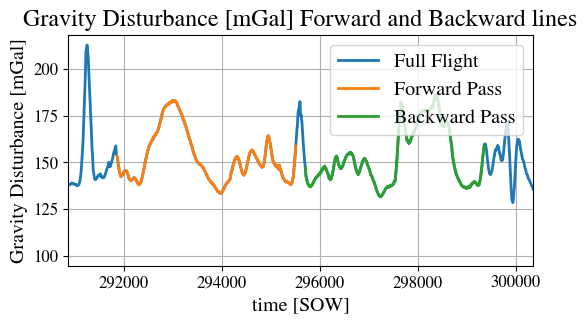

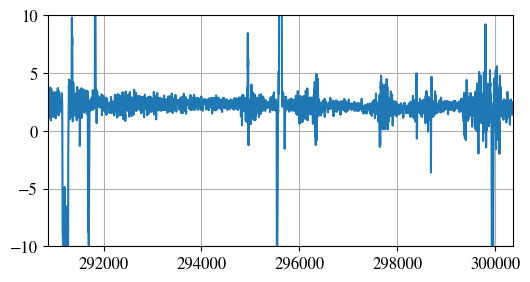

In [55]:
nav.keys()
fig = plt.figure(figsize=(N, N/2))
plt.plot(survey["time"], survey["dg"], label="Full Flight",linewidth=2)
plt.plot(survey["time"][survey["fwd_idx"]], survey["dg"][survey["fwd_idx"]], label="Forward Pass", linewidth=2)
plt.plot(survey["time"][survey["bwd_idx"]], survey["dg"][survey["bwd_idx"]], label="Backward Pass", linewidth=2)

plt.ylabel("Gravity Disturbance [mGal]")
plt.xlabel("time [SOW]")
plt.xlim(survey["time"][survey["fwd_idx"][0]]-1000, survey["time"][survey["bwd_idx"][-1]]+1000)
# plt.ylim(120, 240)
plt.grid()
plt.legend(loc="upper right")

plt.title("Gravity Disturbance [mGal] Forward and Backward lines")
plt.show()

fig = plt.figure(figsize=(N, N/2))
plt.plot(nav.time, nav.roll)
plt.xlim(survey["time"][survey["fwd_idx"][0]]-1000, survey["time"][survey["bwd_idx"][-1]]+1000)
plt.grid()
plt.ylim(-10,10)
plt.show()

## Analysis of Navigation and PPP solution 

In [56]:
nav.keys()

Index(['lat', 'lon', 'h', 'vn', 've', 'vd', 'roll', 'pitch', 'yaw', 'time'], dtype='object')

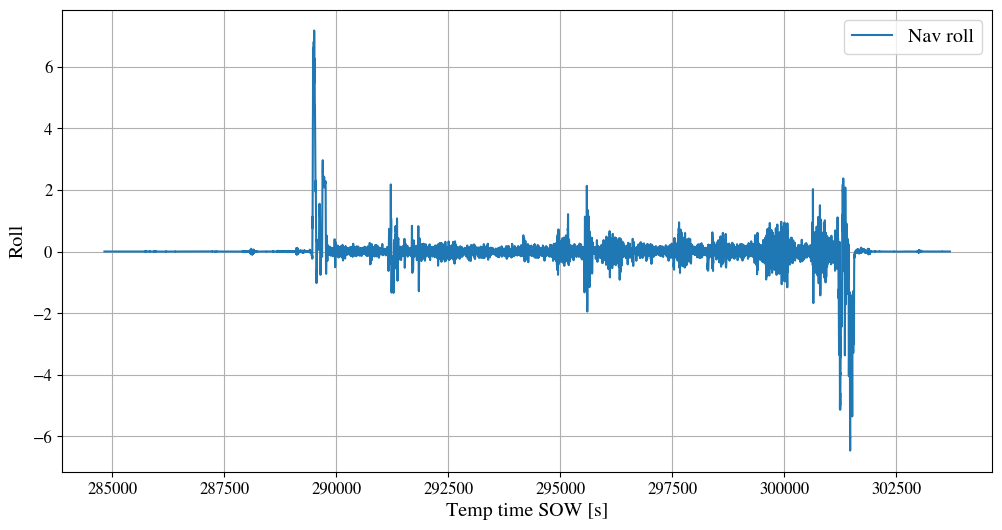

In [57]:
fig = plt.figure(figsize=(N*2, N))
plt.plot(nav.time, nav.vd, label="Nav roll")
#plt.xlim(temp["time"][0], temp["time"][-1])
#plt.ylim(-0.1, 0.1)
plt.ylabel(r"Roll")
plt.xlabel('Temp time SOW [s]')
plt.grid()
plt.legend()

plt.show()

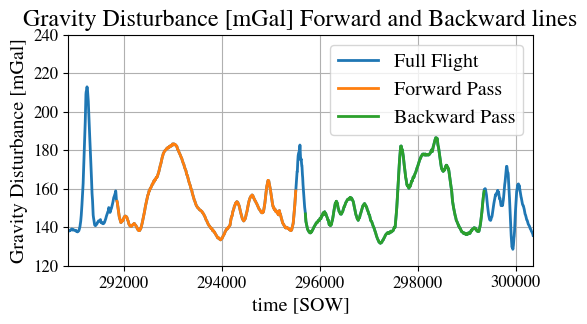

In [58]:
fig = plt.figure(figsize=(N, N/2))
plt.plot(survey["time"], survey["dg"], label="Full Flight",linewidth=2)
plt.plot(survey["time"][survey["fwd_idx"]], survey["dg"][survey["fwd_idx"]], label="Forward Pass", linewidth=2)
plt.plot(survey["time"][survey["bwd_idx"]], survey["dg"][survey["bwd_idx"]], label="Backward Pass", linewidth=2)

plt.ylabel("Gravity Disturbance [mGal]")
plt.xlabel("time [SOW]")
plt.xlim(survey["time"][survey["fwd_idx"][0]]-1000, survey["time"][survey["bwd_idx"][-1]]+1000)
plt.ylim(120, 240)
plt.grid()
plt.legend(loc="upper right")

plt.title("Gravity Disturbance [mGal] Forward and Backward lines")
plt.show()

In [59]:
gnss.keys()

Index(['lat', 'lon', 'h', 'time', 'freeAir_flight', 'roll', 'pitch', 'yaw',
       'imu_lat', 'imu_lon', 'imu_h'],
      dtype='object')

In [60]:
file_res = Path("..", "data", "data_new", "results", "DK22_inat_285.txt")
tempe = pd.read_csv(file_res.as_posix(), skiprows=1, delim_whitespace=True, header = None, 
                  names = ["FlightID", "Lat [deg]", "Lon [deg]", "h [m]", "Bank [deg]", "Elevation [deg]", "Heading [deg]", "g [mGal]", "dg [mGal]", "GPS Time [s]", "DOY [days]", "Lineno"])
TIM = tempe[["FlightID", "Lat [deg]", "Lon [deg]", "h [m]", "Bank [deg]", "Elevation [deg]", "Heading [deg]", "g [mGal]", "dg [mGal]", "GPS Time [s]", "DOY [days]", "Lineno"]].copy()
TIM.columns = ["FlightID", "lat", "lon", "h", "bank", "elevation", "heading", "g", "dg", "GPS_time", "DOY", "lineno"]

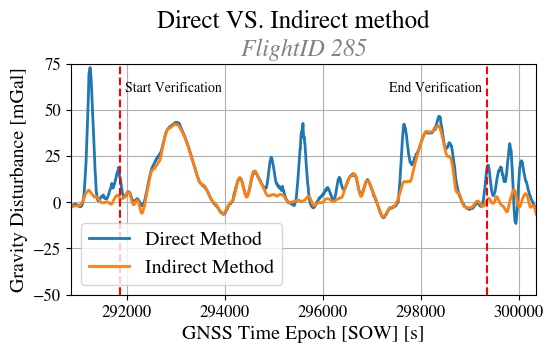

In [61]:
fig = plt.figure(figsize=(N, N/2))
plt.plot(survey["time"], survey["dg"]-140, label="Direct Method",linewidth=2)
plt.plot(TIM.GPS_time, TIM.dg, label="Indirect Method", linewidth=2)
plt.ylabel("Gravity Disturbance [mGal]")
plt.xlabel("GNSS Time Epoch [SOW] [s]")
plt.xlim(survey["time"][survey["fwd_idx"][0]]-1000, survey["time"][survey["bwd_idx"][-1]]+1000)
plt.ylim(-50, 75)
plt.grid()
plt.legend(loc="lower left")
plt.suptitle("Direct VS. Indirect method \n", fontsize=18, y=1.06)
plt.title(r"FlightID 285", color="grey", style='italic')
plt.axvline(x=survey["time"][survey["fwd_idx"][0]], color='red', linestyle="--")
plt.axvline(x=survey["time"][survey["bwd_idx"][-1]], color='red', linestyle="--")
plt.text(survey["time"][survey["fwd_idx"][0]]+100, 60, 'Start Verification', rotation=0)
plt.text(survey["time"][survey["bwd_idx"][-1]]-2000, 60, 'End Verification', rotation=0)

plt.show()

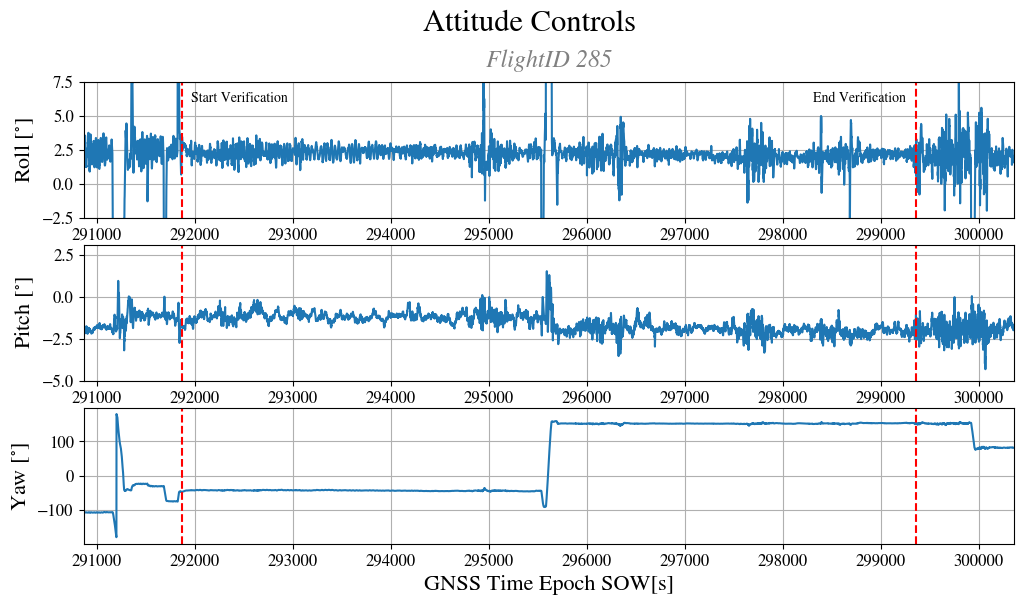

In [62]:
# fig = plt.figure(figsize=(N, N/2))
fig, ax = plt.subplots(3,1, figsize = (N*2,N)) 
plt.suptitle("Attitude Controls \n", fontsize=22, y=1.0)
plt.title(r"FlightID 285", color="grey", style='italic', y=3.45)

ax[0].plot(gnss.time, gnss.roll, label="Roll")
# ax[0].plot(TIM.GPS_time, TIM.bank, label="TIM Roll")
ax[0].grid()
ax[0].set_ylabel("Roll [$^{\circ}$]", fontsize = 16)
# ax[0].legend(loc = "lower center")
ax[0].set_xlim(survey["time"][survey["fwd_idx"][0]]-1000, survey["time"][survey["bwd_idx"][-1]]+1000)
ax[0].locator_params(axis='x', nbins=10)

ax[1].plot(gnss.time, gnss.pitch, label= "Pitch")
# ax[1].plot(TIM.GPS_time, TIM.elevation, label="TIM Pitch")
ax[1].grid()
ax[1].set_ylabel("Pitch [$^{\circ}$]", fontsize = 16)
# ax[1].legend(loc = "lower center")
ax[1].set_xlim(survey["time"][survey["fwd_idx"][0]]-1000, survey["time"][survey["bwd_idx"][-1]]+1000)
ax[1].locator_params(axis='x', nbins=10)
# ax[1].set_xlim(294000, 296000)
# ax[1].set_ylim(-3,2)

ax[2].plot(gnss.time, gnss.yaw, label="Yaw")
# ax[2].plot(TIM.GPS_time, TIM.heading, label="TIM Yaw")
ax[2].grid()
ax[2].set_ylabel(r"Yaw [$^{\circ}$]", fontsize = 16)
ax[2].set_xlabel("GNSS Time Epoch SOW[s]", fontsize = 16)
# ax[2].legend(loc = "lower center")
ax[2].set_xlim(survey["time"][survey["fwd_idx"][0]]-1000, survey["time"][survey["bwd_idx"][-1]]+1000)
ax[2].locator_params(axis='x', nbins=10)
ax[0].axvline(x=survey["time"][survey["fwd_idx"][0]], color='red', linestyle="--")
ax[0].axvline(x=survey["time"][survey["bwd_idx"][-1]], color='red', linestyle="--")
ax[0].text(survey["time"][survey["fwd_idx"][0]]+100, 6, 'Start Verification', rotation=0)
ax[0].text(survey["time"][survey["bwd_idx"][-1]]-1050, 6, 'End Verification', rotation=0)
ax[1].axvline(x=survey["time"][survey["fwd_idx"][0]], color='red', linestyle="--")
ax[1].axvline(x=survey["time"][survey["bwd_idx"][-1]], color='red', linestyle="--")
ax[2].axvline(x=survey["time"][survey["fwd_idx"][0]], color='red', linestyle="--")
ax[2].axvline(x=survey["time"][survey["bwd_idx"][-1]], color='red', linestyle="--")
ax[0].set_ylim(-2.5,7.5)
ax[1].set_ylim(-5,3.1)
plt.show()

In [63]:
veri = np.hstack([survey["fwd_idx"], survey["bwd_idx"]])
print("mean of roll", np.mean(gnss.roll[veri]))
print("varianse of roll", np.var(gnss.roll[veri]))
print("std of roll", np.std(gnss.roll[veri]))

print("mean of pitch", np.mean(gnss.pitch[veri]))
print("varianse of pitch", np.var(gnss.pitch[veri]))
print("std of pitch", np.std(gnss.pitch[veri]))

# yaw1 = np.hstack([gnss.yaw[survey["fwd_idx"]], gnss.yaw[survey["fwd_idx"]]])
# print("mean of yaw", np.mean(yaw1))
# print("varianse of yaw", np.var(yaw1))
# print("std of yaw", np.std(yaw1))


mean of roll 2.34296099
varianse of roll 6.002510081770111
std of roll 2.4500020575032404
mean of pitch -1.5955519465753425
varianse of pitch 0.2772828150204757
std of pitch 0.5265765044326187


Text(0.5, 1.05, 'Attitude analysis, FlightID 285')

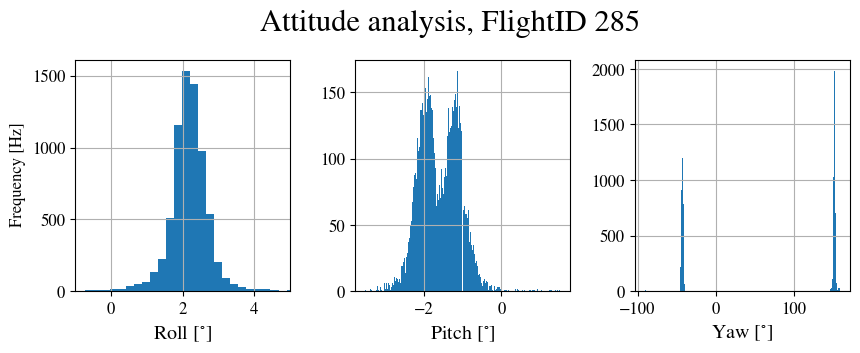

In [64]:
fig, ax = plt.subplots(1, 3, figsize=(10, 3))
ax[0].hist(gnss.roll[veri], bins = 200);
ax[0].grid()
ax[0].set_xlabel(r"Roll [$^{\circ}$]")
ax[0].set_xlim(-1, 5)

ax[1].hist(gnss.pitch[veri], bins = 200);
ax[1].grid()
ax[1].set_xlabel(r"Pitch [$^{\circ}$]")

ax[2].hist(gnss.yaw[veri], bins = 200);
# ax[2].hist(yaw1, bins = 200);

ax[2].grid()
ax[2].set_xlabel(r"Yaw [$^{\circ}$]")
fig.text(0.06, 0.5, 'Frequency [Hz]', va='center', rotation='vertical', fontsize=12)
plt.subplots_adjust(wspace=0.3)
fig.suptitle("Attitude analysis, FlightID 285", fontsize=22, y=1.05)


In [65]:
IS = ds.interpolate_DS(TIM.GPS_time, TIM.dg, 
                                      survey["time"], "linear", "extrapolate")
res_DS2IS = IS.reshape(-1,1) - (survey["dg"]-140)
# res_DS2IS = IS.reshape(-1,1) - dg_corr.reshape(-1,1)

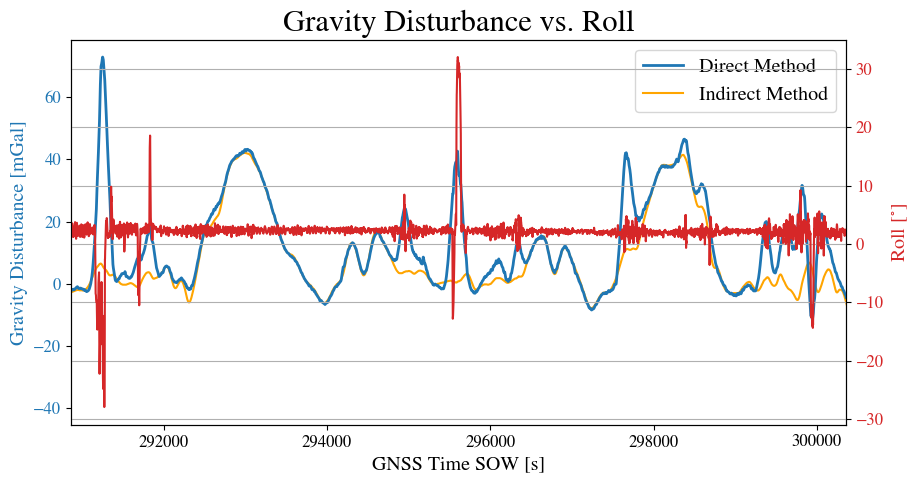

In [66]:
fig, ax1 = plt.subplots(figsize = (10,5))
color = "tab:blue"
ax1.set_xlabel("GNSS Time SOW [s]")
ax1.plot(survey["time"], survey["dg"]-140, label="Direct Method",
         linewidth=2, color=color, zorder=10)
ax1.plot(TIM.GPS_time, TIM.dg, label="Indirect Method", color="orange")
ax1.set_ylabel("Gravity Disturbance [mGal]", color=color)
ax1.tick_params(axis='y', labelcolor=color)
plt.legend()

ax2 = ax1.twinx()
color = "tab:red"
ax2.plot(gnss.time, gnss.roll, label=r"Roll [$^{\circ}$]", color=color)
ax2.set_ylabel("Roll [$^{\circ}$]", color=color)
ax2.tick_params(axis='y', labelcolor=color)
ax2.set_xlim(survey["time"][survey["fwd_idx"][0]]-1000, survey["time"][survey["bwd_idx"][-1]]+1000)
ax2.grid()
plt.title("Gravity Disturbance vs. Roll", fontsize=22)
name = Path("Figures", "dg_vs_roll.pdf")
# Add a vertical grey strip with transparency

# plt.savefig(name)
plt.show()

In [67]:
res_DS2IS[:index].shape
gnss_roll = ds.interpolate_DS(gnss.time, gnss.roll, 
                                      temp["time"], "linear", False, "extrapolate")

roll_but = ds.but2_v2(gnss_roll, 3, 120, 1)

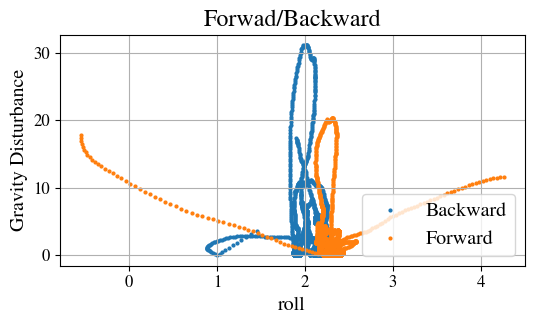

In [68]:
fig = plt.figure(figsize=(N, N/2))
# plt.scatter(np.gradient(gnss.roll[survey["bwd_idx"]]), np.abs(res_DS2IS[survey["bwd_idx"]]), 1)
plt.scatter(roll_but[:index][survey["bwd_idx"]],np.abs(res_DS2IS)[survey["bwd_idx"]], 4, label="Backward")
plt.scatter(roll_but[:index][survey["fwd_idx"]],np.abs(res_DS2IS)[survey["fwd_idx"]], 4, label="Forward")
plt.ylabel("Gravity Disturbance")
plt.xlabel("roll")
plt.grid()
# plt.xlim(1.5, 2.5)
plt.legend(loc="lower right")
plt.title("Forwad/Backward")
plt.show()

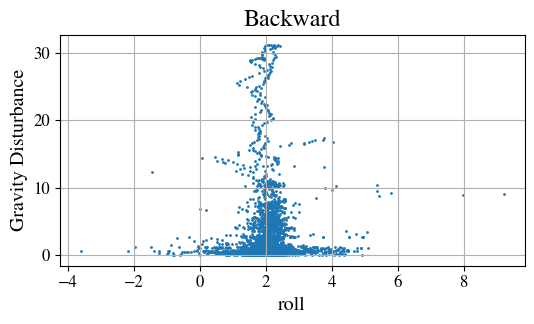

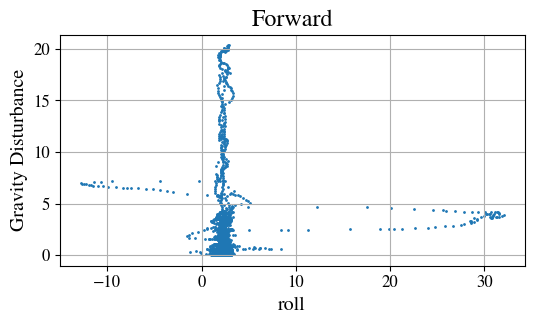

In [69]:
fig = plt.figure(figsize=(N, N/2))
# plt.scatter(np.gradient(gnss.roll[survey["bwd_idx"]]), np.abs(res_DS2IS[survey["bwd_idx"]]), 1)
plt.scatter(gnss.roll[survey["bwd_idx"]], np.abs(res_DS2IS[survey["bwd_idx"]]), 1)
plt.ylabel("Gravity Disturbance")
plt.xlabel("roll")
plt.grid()
plt.title("Backward")
plt.show()

fig = plt.figure(figsize=(N, N/2))
plt.scatter(gnss.roll[survey["fwd_idx"]],  np.abs(res_DS2IS[survey["fwd_idx"]]), 1)
plt.ylabel("Gravity Disturbance")
plt.xlabel("roll")
plt.grid()
plt.title("Forward")
plt.show()

In [70]:
print(ds.RMS(res_DS2IS))

12.227957730764455


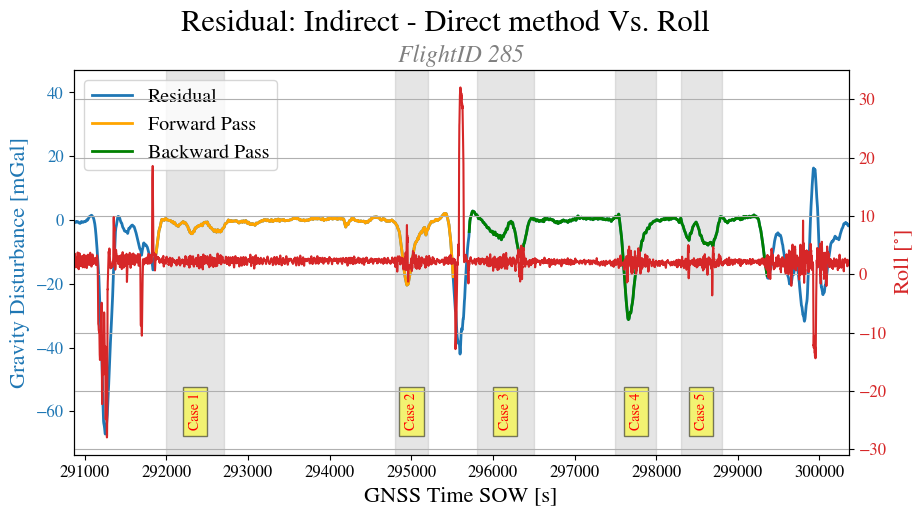

In [71]:
roll_but2 = ds.but2_v2(gnss.roll.values, 3, 120, 1)

fig, ax1 = plt.subplots(figsize = (10,5))
color = "tab:blue"
ax1.set_xlabel("GNSS Time SOW [s]", fontsize=16)
ax1.plot(survey["time"], res_DS2IS, label="Residual",
         linewidth=2, color=color, zorder=10)
# ax1.plot(TIM.GPS_time, TIM.dg, label="Indirect Method", color="orange")
ax1.set_ylabel("Gravity Disturbance [mGal]", color=color, fontsize=16)
ax1.tick_params(axis='y', labelcolor=color)
ax1.plot(survey["time"][survey["fwd_idx"]], res_DS2IS[survey["fwd_idx"]], color="orange", zorder=100, label="Forward Pass", linewidth=2)
ax1.plot(survey["time"][survey["bwd_idx"]], res_DS2IS[survey["bwd_idx"]], color="green", zorder=100, label="Backward Pass", linewidth=2)
plt.legend()

# [survey["fwd_idx"]]

ax2 = ax1.twinx()
color = "tab:red"
ax2.plot(gnss.time, gnss.roll, label=r"Roll [$^{\circ}$]", color=color)
# ax2.plot(gnss.time, roll_but2, label=r"Roll [$^{\circ}$]", color=color)
ax2.set_ylabel("Roll [$^{\circ}$]", color=color, fontsize=16)
ax2.tick_params(axis='y', labelcolor=color)
ax2.set_xlim(survey["time"][survey["fwd_idx"][0]]-1000, survey["time"][survey["bwd_idx"][-1]]+1000)
ax2.grid()
ax2.locator_params(axis='x', nbins=10)
# plt.title("Difference (IS - DS) vs. Roll", fontsize=22)

plt.suptitle("Residual: Indirect - Direct method Vs. Roll \n", fontsize=22, y=1.0)
plt.title(r"FlightID 285", color="grey", style='italic')


name = Path("Figures", "DS_IS_vs_roll.pdf")
ax1.axvspan(297500, 298000, alpha=0.2, color='grey')
ax1.axvspan(298300, 298800, alpha=0.2, color='grey')
ax1.axvspan(292000, 292700, alpha=0.2, color='grey')
ax1.axvspan(294800, 295200, alpha=0.2, color='grey')
ax1.axvspan(295800, 296500, alpha=0.2, color='grey')
ax1.text((292000+292700)/2, -60, s=r"Case 1", ha='center', va='center', fontdict=dict(color="red",size=10), 
         bbox=dict(facecolor="yellow",alpha=0.5), rotation=90)
ax1.text((294800+295200)/2, -60, s=r"Case 2", ha='center', va='center', fontdict=dict(color="red",size=10), 
         bbox=dict(facecolor="yellow",alpha=0.5), rotation=90)
ax1.text((295800+296500)/2, -60, s=r"Case 3", ha='center', va='center', fontdict=dict(color="red",size=10), 
         bbox=dict(facecolor="yellow",alpha=0.5), rotation=90)
ax1.text((297500+298000)/2, -60, s=r"Case 4", ha='center', va='center', fontdict=dict(color="red",size=10), 
         bbox=dict(facecolor="yellow",alpha=0.5), rotation=90)
ax1.text((298300+298800)/2, -60, s=r"Case 5", ha='center', va='center', fontdict=dict(color="red",size=10), 
         bbox=dict(facecolor="yellow",alpha=0.5), rotation=90)
plt.savefig(name)
plt.show()


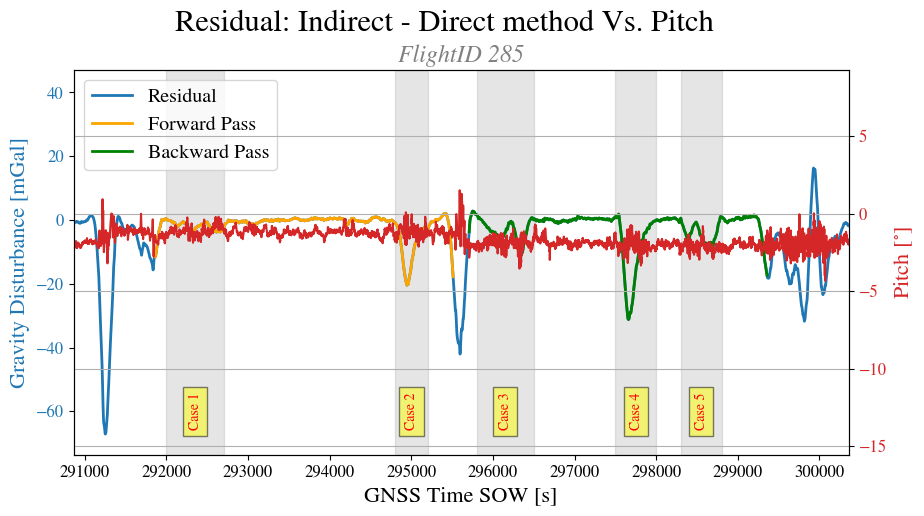

In [72]:
roll_but2 = ds.but2_v2(gnss.roll.values, 3, 120, 1)

fig, ax1 = plt.subplots(figsize = (10,5))
color = "tab:blue"
ax1.set_xlabel("GNSS Time SOW [s]", fontsize=16)
ax1.plot(survey["time"], res_DS2IS, label="Residual",
         linewidth=2, color=color, zorder=10)
# ax1.plot(TIM.GPS_time, TIM.dg, label="Indirect Method", color="orange")
ax1.set_ylabel("Gravity Disturbance [mGal]", color=color, fontsize=16)
ax1.tick_params(axis='y', labelcolor=color)
ax1.plot(survey["time"][survey["fwd_idx"]], res_DS2IS[survey["fwd_idx"]], color="orange", zorder=100, label="Forward Pass", linewidth=2)
ax1.plot(survey["time"][survey["bwd_idx"]], res_DS2IS[survey["bwd_idx"]], color="green", zorder=100, label="Backward Pass", linewidth=2)
plt.legend()

# [survey["fwd_idx"]]

ax2 = ax1.twinx()
color = "tab:red"
ax2.plot(gnss.time, gnss.pitch, label=r"Pitch [$^{\circ}$]", color=color)
# ax2.plot(gnss.time, roll_but2, label=r"Roll [$^{\circ}$]", color=color)
ax2.set_ylabel("Pitch [$^{\circ}$]", color=color, fontsize=16)
ax2.tick_params(axis='y', labelcolor=color)
ax2.set_xlim(survey["time"][survey["fwd_idx"][0]]-1000, survey["time"][survey["bwd_idx"][-1]]+1000)
ax2.grid()
ax2.locator_params(axis='x', nbins=10)
# plt.title("Difference (IS - DS) vs. Roll", fontsize=22)

plt.suptitle("Residual: Indirect - Direct method Vs. Pitch \n", fontsize=22, y=1.0)
plt.title(r"FlightID 285", color="grey", style='italic')


name = Path("Figures", "DS_IS_vs_roll.pdf")
ax1.axvspan(297500, 298000, alpha=0.2, color='grey')
ax1.axvspan(298300, 298800, alpha=0.2, color='grey')
ax1.axvspan(292000, 292700, alpha=0.2, color='grey')
ax1.axvspan(294800, 295200, alpha=0.2, color='grey')
ax1.axvspan(295800, 296500, alpha=0.2, color='grey')
ax1.text((292000+292700)/2, -60, s=r"Case 1", ha='center', va='center', fontdict=dict(color="red",size=10), 
         bbox=dict(facecolor="yellow",alpha=0.5), rotation=90)
ax1.text((294800+295200)/2, -60, s=r"Case 2", ha='center', va='center', fontdict=dict(color="red",size=10), 
         bbox=dict(facecolor="yellow",alpha=0.5), rotation=90)
ax1.text((295800+296500)/2, -60, s=r"Case 3", ha='center', va='center', fontdict=dict(color="red",size=10), 
         bbox=dict(facecolor="yellow",alpha=0.5), rotation=90)
ax1.text((297500+298000)/2, -60, s=r"Case 4", ha='center', va='center', fontdict=dict(color="red",size=10), 
         bbox=dict(facecolor="yellow",alpha=0.5), rotation=90)
ax1.text((298300+298800)/2, -60, s=r"Case 5", ha='center', va='center', fontdict=dict(color="red",size=10), 
         bbox=dict(facecolor="yellow",alpha=0.5), rotation=90)
plt.savefig(name)
plt.show()


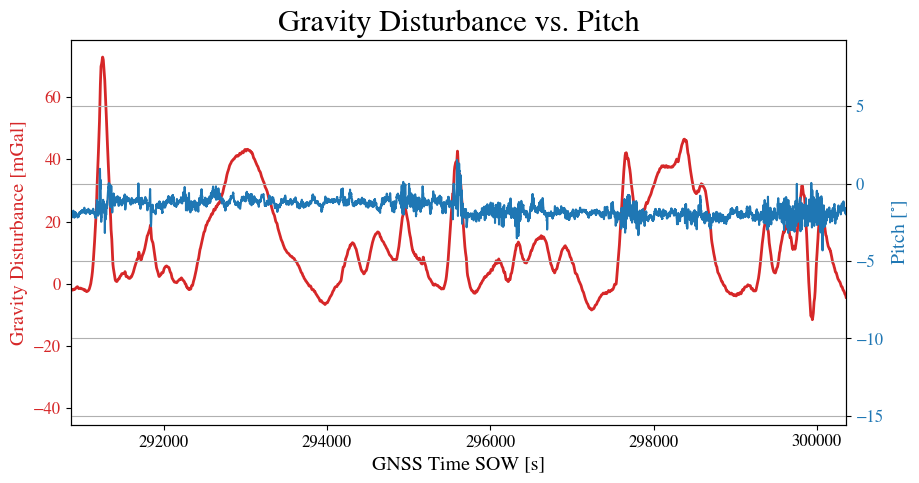

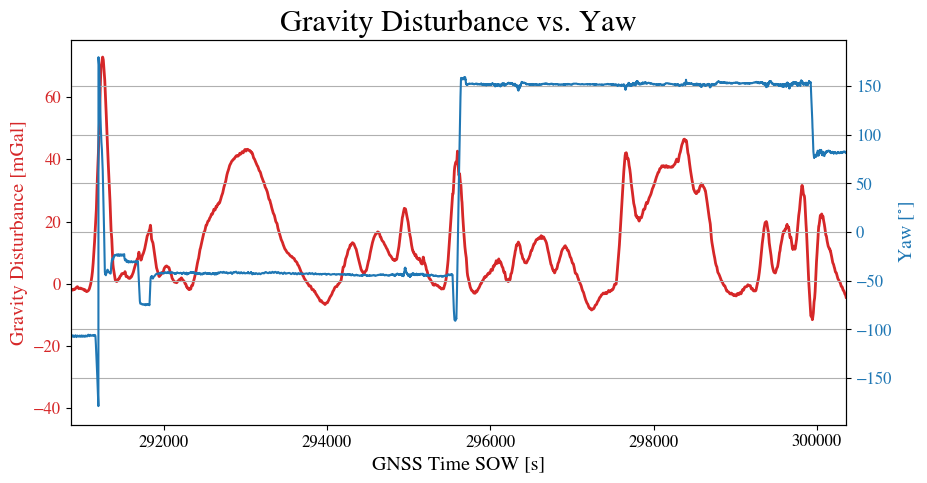

In [73]:
fig, ax1 = plt.subplots(figsize = (10,5))
color = "tab:red"
ax1.set_xlabel("GNSS Time SOW [s]")
ax1.plot(survey["time"], survey["dg"]-140, label="Direct Method",linewidth=2, color=color)
ax1.set_ylabel("Gravity Disturbance [mGal]", color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()
color = "tab:blue"
ax2.plot(gnss.time, gnss.pitch, label=r"Pitch [$^{\circ}$]", color=color)
ax2.set_ylabel("Pitch [$^{\circ}$]", color=color)
ax2.tick_params(axis='y', labelcolor=color)
ax2.set_xlim(survey["time"][survey["fwd_idx"][0]]-1000, survey["time"][survey["bwd_idx"][-1]]+1000)
plt.grid()
plt.title("Gravity Disturbance vs. Pitch", fontsize=22)
plt.show()


fig, ax1 = plt.subplots(figsize = (10,5))
color = "tab:red"
ax1.set_xlabel("GNSS Time SOW [s]")
ax1.plot(survey["time"], survey["dg"]-140, label="Direct Method",linewidth=2, color=color)
ax1.set_ylabel("Gravity Disturbance [mGal]", color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()
color = "tab:blue"
ax2.plot(gnss.time, gnss.yaw, label=r"Yaw [$^{\circ}$]", color=color)
ax2.set_ylabel("Yaw [$^{\circ}$]", color=color)
ax2.tick_params(axis='y', labelcolor=color)
ax2.set_xlim(survey["time"][survey["fwd_idx"][0]]-1000, survey["time"][survey["bwd_idx"][-1]]+1000)
plt.grid()
plt.title("Gravity Disturbance vs. Yaw", fontsize=22)
plt.show()